In [1]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size
pd.set_option('display.max_rows', None)
thick_size=16
label_size=20

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2)) ##U(1)_Y gauge coupling (also the electron charge in dimensionless units)
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant
del alpha


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0,Lam=500):
        self.Lam=Lam
        self.yt=1/(1+u**2/Lam**2)**.5
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2

    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot

    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + self.yt**2/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)

        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B

        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys

   


    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=self.yt**2*h**2/2*(1+s**2/self.Lam**2)
        #mt=self.yt**2*h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        dof = np.array([12])
        return M, dof, Mphys


    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.

        return [np.array([v,self.u])]

    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and abs(self.lammix)<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            #print("Model is theoretically consistent \n")
            return True
        else:
            #print("Model is NOT theoretically consistent \n")
            return False


    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")

    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0.
        Doesn't work for Z_2 symmetric potential!!!"""
        n=100
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            #print("Model has a Z2 symmetry in the potential \n")
            #print("isEWSB=True \n")
            return True,X_EW
        #------------
        X0=self.findMinimum([0,100],0)
        if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            #print("Global minimum found at X=",X0,"\n")
            #print("isEWSB=False \n")
            return False, X0
        X0=self.findMinimum([0,-100],0)
        if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(abs(X0[0])-v)>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1:
            #print("Global minimum found at X=",X0,"\n")
            #print("isEWSB=False \n")
            return False, X0
         
        ###This loop search for a global minima randomly
        for i in range(n):
            x1=np.random.uniform(-100,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=self.Vtot(X_EW,0) and abs(X0[0])-v>10 and abs(self.Vtot(X0,0)-self.Vtot(X_EW,0))>1e2:
                #print("Global minimum found at X=",X0,"\n")
                #print("isEWSB=False \n")
                return False, X0
        #print("isEWSB=True \n")
        return True,X_EW


#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTION
#######HERE ARE MY OWN FUNCTIONS#######HERE ARE MY OWN FUNCTIONS
#######HERE ARE MY OWN FUNCTIONS

def g_loop(z):
    """Loop integral for EDM. Extracted from (A.2) of 1712.09613"""
    g_integrand=lambda x: np.log(x*(1-x)/z)/(x*(1-x)-z)
    integral=integrate.quad(g_integrand,0,1)[0]
    return z*0.5*integral


def d_eEDM(X):
    X=np.array(X)
    theta,ms,Lam=X[...,0],X[...,1],X[...,2]
    G_f=1/2**.5/v**2
    ee=g1
    me=0.5*1e-3
    mt=172.9
    alpha=1/137
    numeric=ee/3/np.pi**2*alpha*G_f*v/2**.5/np.pi/mt*me*(v/2**.5/Lam)
    out=np.sin(theta)*np.cos(theta)*(-g_loop(mt**2/mh**2) + g_loop(mt**2/ms**2))
    return np.abs(numeric*out)

d_eEDM_bound=1.89*10**(-16) 


def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum
    ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity



def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restored at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"

    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR

    


def beta_GW(Tnuc,dS_TdT):
    ###This code defines the parameter beta relevant for stochastic GW spectrum
    num_dof=g_star(Tnuc)
    Hubble=np.sqrt(num_dof*np.pi**2/90)*Tnuc**2/Mplanck
    beta=Hubble*Tnuc*dS_TdT
    return beta/Hubble


def get_trans_index(allTrans):
    """Returns the index of the relevant transition"""
    #allTrans=m.TnTrans
    Num_Trans=len(allTrans)
    if Num_Trans==0:
        print("No transitions were found")
        return 
    else:
        indx=Num_Trans-1
        for Trans in allTrans[::-1]:
            if Trans["trantype"]==1 and (np.sum((abs(Trans["high_vev"])-abs(Trans["low_vev"]))**2)**0.5)>=10:
                return indx
            else:
                indx-=1
                continue
    print("\n No relevant transition")      
    return None





In [2]:
##########HERE STARTS TRANSPORT EQUATIONS
##########HERE STARTS TRANSPORT EQUATIONS
##########HERE STARTS TRANSPORT EQUATIONS
##########HERE STARTS TRANSPORT EQUATIONS
def c_dist(x,m,n,p):
    """
    From 2007.10935, formula (8).
    Integrates the derivative of the Bose-Einstein or Fermi-Dirac distribution
    in the fluid frame (vw=0) and weighted by momentum^n/energy^m.  

    Parameters
    ----------
    x : float (mass divided by temperature)
    m: integer, power of energy in denominator
    n: integer, power of momenta in numerator
    p: integer /p=0 for Bosons and p=1 for Fermions
    
    Returns
    -------
    float, the result of integration
    """
    if (n%2)==0:
        integ=integrate.quad(lambda ee: \
                             (ee**2-x**2)**((n+1)/2)/ee**(m-1)*np.e**(-ee)/(1-(-1)**p*np.e**(-ee))**2,\
                             x, np.inf)
        integ_1=1/(4*np.pi**2)*(2/(1+n))*integ[0]
        return integ_1
    else:
        return 0
    


def d_dist(x,m,n,p):
    """
    From 2007.10935, formula (8).
    Integrates the Bose-Einstein or Fermi-Dirac distribution
    weighted by momentum^n/energy^m.  

    Parameters
    ----------
    x : float (mass divided by temperature)
    m: integer 
    n: integer 
    p: integer /p=0 for Bosons and p=1 for Fermions
    
    Returns
    -------
    float, the result of integration
    """
    if (n%2)==0:
        integ=integrate.quad(lambda ee: \
                             (ee**2-x**2)**((n+1)/2)/ee**(m-1)*np.e**(-ee)/(1-(-1)**p*np.e**(-ee)),\
                             x, np.inf)
        integ_1=1/(4*np.pi**2)*(2/(1+n))*integ[0]
        return integ_1
    else:
        return 0

def A_matrix(vw,x,p):
    """
    This function defines the matrix of coefficients for the
    ODE, see eq. (7) of 2007.10935.  

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    x : float (mass divided by temperature)
    p: integer| n=0 for Bosons and n=1 for Fermions
    
    Returns
    -------
    A: np.array| 3x3 matrix of coefficients.
    """
    gamma=1/(1-vw**2)**0.5
    row1=[gamma*vw*c_dist(x,0,0,p),gamma*vw*c_dist(x,-1,0,p),gamma*d_dist(x,0,0,p)]
    row2=[gamma**2*vw*(c_dist(x,-1,0,p)+c_dist(x,1,2,p)),gamma**2*vw*(c_dist(x,-2,0,p)+c_dist(x,0,2,p)),
          gamma**2*(d_dist(x,-1,0,p)+vw**2*d_dist(x,1,2,p))]
    row3=[gamma*vw**2*c_dist(x,0,0,p)+1/gamma**3*sum(vw**(2*n-2)*c_dist(x,2*n,2*n,p) for n in range(1, 12)),
          c_dist(x,1,2,p)/gamma**3+gamma*vw**2*c_dist(x,-1,0,p)+vw/gamma**3*sum(vw**(2*n-3)*c_dist(x,2*n-1,2*n,p) for n in range(2, 12)),
          gamma*vw*d_dist(x,0,0,p)]

              
    Amat=np.array([row1,row2,row3])
    return Amat


def A_fluid(h0,vw,Lh,z,T):
    """
    This function defines the FULL matrix of coefficients for the
    ODE, see eq. (15) of 2007.10935.  

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    z : float (direction transverse to the wall)
    T: float (Temperature)
    
    Returns
    -------
    A: np.array| 6x6 matrix of coefficients.
    """
    xw=(h_profile(z,Lh,h0)**2/6*(3*g**2/2+g1**2))**0.5/T
    xt=h_profile(z,Lh,h0)/2**0.5/T
    A_fl1=np.concatenate((A_matrix(vw,xw,0),np.zeros((3,3))),axis=1)
    A_fl2=np.concatenate((np.zeros((3,3)),A_matrix(vw,xt,1)),axis=1)
    A_fl=np.concatenate((A_fl1,A_fl2),axis=0)
    return A_fl


def Gamma_W(vw,T):
    """
    This function defines the matrix coming from the collision
    term, see eq.(B6)

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    T: float (Temperature)
    
    Returns
    -------
    Gamma: np.array| 3x3 matrix of coefficients.
    """
    gamma=1/(1-vw**2)**0.5
    G11=0.00239
    G21=0.00512*gamma
    G12=0.00512
    G22=0.0174*gamma
    G13=(4.10*vw-3.28*vw**2+5.51*vw**3-4.47*vw**4)*10**(-3)
    G23=gamma*(1.36*vw+0.610*vw**2-2.90*vw**3+1.36*vw**4)*10**(-2)
    G33=(2.42-1.33*vw**2+3.14*vw**3-2.43*vw**4)*10**(-3)
    G31=(1.18*vw+2.79*vw**2-5.31*vw**3+3.66*vw**4)*10**(-3)
    G32=(2.48*vw+6.27*vw**2-11.9*vw**3+8.12*vw**4)*10**(-3)
    
    return T*np.array([[G11,G12,G13],[G21,G22,G23],[G31,G32,G33]])


def Gamma_t(vw,T):
    """
    This function defines the matrix coming from the collision
    term, see eq.(B6)

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    T: float (Temperature)
    
    Returns
    -------
    Gamza: np.array| 3x3 matrix of coefficients.
    """
    gamma=1/(1-vw**2)**0.5
    G11=0.00196
    G21=0.00445*gamma
    G12=0.00445
    G22=0.0177*gamma
    G13=(5.36*vw-4.49*vw**2+7.44*vw**3-5.90*vw**4)*10**(-3)
    G23=gamma*(1.67*vw+1.38*vw**2-5.46*vw**3+2.85*vw**4)*10**(-2)
    G33=(4.07-2.14*vw**2+4.76*vw**3-4.37*vw**4)*10**(-3)
    G31=(0.948*vw+2.38*vw**2-4.51*vw**3+3.07*vw**4)*10**(-3)
    G32=(2.26*vw+4.82*vw**2-9.32*vw**3+6.54*vw**4)*10**(-3)
    
    return T*np.array([[G11,G12,G13],[G21,G22,G23],[G31,G32,G33]])



def my_Gamma(h0,vw,Lh,z,T):
    """
    This function defines the FULL Gamma matrix of collision terms for the
    ODE, see eq. (16) of 2007.10935 and returns the multiplication of the inverse
    of A_fluid times Gamma.  

    Parameters
    ----------
    vw : float (the bubble wall velocity)
    z : ndarray (direction transverse to the wall)
    T: float (Temperature)
    
    Returns
        -------
    Gamma: np.array| 6x6 matrix, the multiplication of the inverse of A_fluid times Gamma
    
    """
    ####The following code defines the diagonal part of the gamma
    ## Matrix as defined in eq. (16)
    gam__diagupper=np.concatenate((Gamma_W(vw,T),np.zeros((3,3))),axis=1)
    gam__diaglower=np.concatenate((np.zeros((3,3)),Gamma_t(vw,T)),axis=1)
    gamma_diag=np.concatenate((gam__diagupper,gam__diaglower),axis=0)
    ###The following matrices correspond to projection matrices. Defined in the paper.
    P_1=np.array([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
    P_2=np.array([[1.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,1.0]])
    P_3=np.array([[0.0,0.0,0.0],[1.0,0.0,0.0],[0.0,0.0,0.0]])
    ###The following matrices correspond to background collision terms
    Gamma_bgW=-9*Gamma_W(vw,T)
    Gamma_bgt=-12*Gamma_t(vw,T)
    ###The following matrices correspond to eqn. (11)
    Nb=19 #number of bosons
    Nf=78 #number of fermions
    Abg=Nb*A_matrix(vw,0,0)+Nf*A_matrix(vw,0,1)
    ###The following code defines the matrix written in eq. (13) 
    ## where the bottom right block of Abg is inverted and 
    # the rest of the matrix elements are zero
    Abg_inv=np.dot(np.dot(P_2,Abg),P_1)+P_3
    Abg_inv=np.linalg.inv(Abg_inv)-np.transpose(P_3)
    ####The following code defines the non-diagonal part of the gamma
    ## Matrix as defined in the second term of eq. (16)
    gam__nondiagupper=np.concatenate((np.dot(Abg_inv,Gamma_bgW),\
                                      np.dot(Abg_inv,Gamma_bgt)),axis=1)
    gam__nondiaglower=np.concatenate((np.dot(Abg_inv,Gamma_bgW),\
                                      np.dot(Abg_inv,Gamma_bgt)),axis=1)
    gamma_nondiag=np.concatenate((gam__nondiagupper,gam__nondiaglower),axis=0)
    ##We define the total gamma matrix below
    gamma_tot= np.array([(np.dot(np.linalg.inv(A_fluid(h0,vw,Lh,i,T)),gamma_diag)-gamma_nondiag) for i in z])
    return gamma_tot 


def source_A(h0,vw,Lh,z,T):
    """
    This function calculates the source term, see eq. (9) and multplies it by 
    the inverse of A_fluid from the left.
    
    Parameters
    ----------
    vw : float (the bubble wall velocity)
    z : ndarray (direction transverse to the wall)
    T: float (Temperature)
    
    Returns
    -------
    Gamma: np.array| 6x1 matrix, the multiplication of the inverse of A_fluid times S
        
    """
    wholesource=[]
    for i in z:
        gamma=1/(1-vw**2)**0.5
        xw=(h_profile(i,Lh,h0)**2/6*(3*g**2/2+g1**2))**0.5/T
        xt=h_profile(i,Lh,h0)/2**0.5/T
        mwprime=Dh_profile(i,Lh,h0)*(1/6*(3*g**2/2+g1**2))**0.5
        mtprime=Dh_profile(i,Lh,h0)/2**0.5
        Source=np.array([xw*mwprime*(c_dist(xw,1,0,0)),\
                         xw*mwprime*(gamma*c_dist(xw,0,0,0)),\
                         xw*mwprime*(vw*c_dist(xw,1,0,0)-1/gamma**2*sum(vw**(2*n-1)*c_dist(xw,2*n+1,2*n,0) for n in range(1, 12))),\
                         xt*mtprime*(c_dist(xt,1,0,1)),\
                         xt*mtprime*(gamma*c_dist(xt,0,0,1)),\
                         xt*mtprime*(vw*c_dist(xt,1,0,1)-1/gamma**2*sum(vw**(2*n-1)*c_dist(xt,2*n+1,2*n,1) for n in range(1, 12)))])
        Source*=vw*gamma/T
        wholesource.append(np.dot(np.linalg.inv(A_fluid(h0,vw,Lh,i,T)),Source))
    return np.array(wholesource)

def Tranport_eqs(z, q,damping,source):
    """
    This function defines the differential equation to be solved. 
    It corresponds to eq. (14)
    
    Parameters
    ----------
    z : ndarray, the size of the integration region
    q: array (6D), the value of the perturbations
    
    Returns
    -------
    dq/dz, array    
    """
    rows=[]
    #damping=inter_gamma_matrix
    #source=inter_source

    for i in range(6):
        elem=[]
        for j in range(6):
            elem.append(-damping[i][j](z)*q[j])
        rows.append(sum(elem)+source[i](z))
    rows=tuple(rows)
    return np.vstack(rows)
    
def bc(ya, yb):
    """
    This code defines the boundary conditions to be used by BVP
    """
    return np.array([ya[0],yb[0],ya[3],yb[3],ya[1], ya[4]])
    #return np.array([ya[0],yb[0],ya[3],yb[3],ya[1]-ya[2], ya[4]-ya[5]])

    #return np.array([ya[0],yb[0],ya[3],yb[3],ya[1]**2+ya[2]**2 ,ya[4]**2+ya[5]**2])


def background_eqs(vw,z,q,T,sol):
    """
    This function defines the differential equation to be solved. 
    It corresponds to eq. (12)
    
    Parameters
    ----------
    z : ndarray, the size of the integration region
    q: array (6D), the value of the perturbations
    
    Returns
    -------
    dq/dz, array    
    """
    Gamma_bgW=-9*Gamma_W(vw,T)
    Gamma_bgt=-12*Gamma_t(vw,T)
    Nb=20 #number of bosons
    Nf=78 #number of fermions
    Abg=Nb*A_matrix(vw,0,0)+Nf*A_matrix(vw,0,1)
    P_1=np.array([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
    P_2=np.array([[1.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,1.0]])
    P_3=np.array([[0.0,0.0,0.0],[1.0,0.0,0.0],[0.0,0.0,0.0]])
    Abg_inv=np.dot(np.dot(P_2,Abg),P_1)+P_3
    Abg_inv=np.linalg.inv(Abg_inv)-np.transpose(P_3)
    At=np.dot(Abg_inv,Gamma_bgt)
    Aw=np.dot(Abg_inv,Gamma_bgW)
    qw=sol.sol(z)[0:3]
    qt=sol.sol(z)[3:6]
    output=-np.dot(At,qt)-np.dot(Aw,qw)
    return output[1:]
    
def bc_background(ya, yb):
    """
    This code defines the boundary conditions to be used by BVP
    """
    return np.array([ya[0], ya[1]])
    

def d_dist_v(x,vw,p):
    """
    Inegral of distribution function in the wall frame divided by pz. 
    Given by eq. (8) with m=0 and n=-1.
    
    Parameters
    ----------
    x : float (mass divided by temperature)
    p: integer /p=0 for Bosons and p=1 for Fermions
    
    Returns
     -------
    float, the result of integration
    """
    ff=lambda x,v,e:2*v*(e**2-x**2)**0.5 + 2*e*(1-v**2)*np.arctanh((e**2-x**2)**0.5/e/v) if (e**2-x**2)**0.5/e/v<1 \
    else 2*v*(e**2-x**2)**0.5 + 2*e*(1-v**2)*np.log((e**2-x**2)**0.5/e/v)
    integ=integrate.quad(lambda e: np.exp(-e)/(1-(-1)**p*np.exp(-e))*ff(x,vw,e), x, np.infty)
    return integ[0]/4/np.pi**2




######HERE STARTS HYDRODYNAMIC EQUATIONS FROM REF.1004.4187
########################
########################
##############################
##############################
##############
##3######3
############## MORE FORMULAS RELEVANT 
 ##############FOR HYDRODYNAMICS
 ############## OF THE TEMPERATURE

def Lorentz_mu(v1,v2):
    """Lorentz transformation. Usually to the fluid frame"""
    return (v1-v2)/(1-v1*v2)

def hydrodynamic_eq(xi,v):
    """Parametrizes the equation for the fluid velocity. 
    Given by eqn. (2.27) in 1004.4187"""
    gamma=lambda vv:1/(1-vv**2)**0.5
    dv_dxi = 2*v/xi*(gamma(v)**2*(1-v*xi)*(Lorentz_mu(xi,v)**2/cs**2-1))**(-1)
    return dv_dxi



def Tp_exp_equation(xi,v_fun):
    """This function is the inegrand of the hydrodynamic relation log(T)/T. """
    v=v_fun(xi)
    return -2*cs**2*v*(xi-v)/xi/((xi-v)**2-cs**2*(1-v*xi)**2)
    
def sol_detonation_odeint(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for detonations.
    For detonation the fluid in front of the wall is at rest (for the fluid rest frame)"""
    vp=xi
    if vp<=cs:
        print("Not a detonation. Velocity too low. ")
        return 
    det=-12*vp**2+(-1-3*vp**2+3*alpha_p*(1-vp**2))**2
    if det<0:
        print("Negative determinant")
        return 
    vm=(1+3*vp**2-3*alpha_p*(1-vp**2))/6/vp
    vm1=vm-1/6/vp*(det)**(0.5)
    vm2=vm+1/6/vp*(det)**(0.5)
    ##" strong detonations (v− < cs−) are not consistent solutions of the fluid equations,"
    vm=max([vm1,vm2])  ##Always choose the maximum value. 
    if vm==cs:
        print("Jouguet detonation")
    ###Now solve it:
    v_init=Lorentz_mu(vp,vm)
    v_range=np.linspace(cs,vp)[::-1]
    solut=integrate.odeint(hydrodynamic_eq, v_init, v_range,tfirst=True)
    return np.vstack((v_range,solut.T))


    
    
def sol_deflagration_odeint(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for deflagrations.
    For deflagration the fluid behind the wall is at rest (for the fluid rest frame)"""
    vm=xi
    det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
    if det<0:
        print("Negative determinant")
        return 
    vp=(1/6/vm+vm/2)/(1+alpha_p)
    vp1=vp-det**0.5/(1+alpha_p)
    vp2=vp+det**0.5/(1+alpha_p)
    ###Now solve it:
    v_init=Lorentz_mu(vm,vp1)
    v_range=np.linspace(vm,1)
    solut=integrate.odeint(hydrodynamic_eq,v_init, v_range,tfirst=True)
    return np.vstack((v_range,solut.T))



def sol_deflagration_solve_ivp(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for deflagrations.
    For deflagration the fluid behind the wall is at rest (in the fluid rest frame)
    
    Parameters
    ----------------
    xi: fluid velocity, self-similar variable
    alpha_p: The strength of the phase transition.
    """
    if xi>cs:
        print("Velocity is supersonic. Not a deflagration")
        return 
    vm=xi
    det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
    if det<0:
        print("Negative determinant")
        return 
    vp=(1/6/vm+vm/2)/(1+alpha_p)
    vp1=vp-det**0.5/(1+alpha_p)
    vp2=vp+det**0.5/(1+alpha_p)
    ###Now solve it:
    v_init=Lorentz_mu(vm,vp1)
    v_range=(vm,1)
    def myevent(xi,v):
        """Position of the shock-front"""
        return Lorentz_mu(xi,v)*xi-cs**2
    myevent.terminal=True
    solut=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
    return [solut.t,solut.y[0]]



def sol_detonations_solve_ivp(xi,alpha_p):
    """This function solves the hydrodynamic eqns. for detonations:
       BOTH strong detonations and hybrids.
    For strong detonations the fluid in front of the wall is at rest (for the fluid rest frame).
    Hybrids are Jouguet detonations v-=cs"""
    xi_Jouguet=((alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
    if xi<cs:
        print("Not a detonation. Velocity too low. ")
        return 
    elif (xi<=xi_Jouguet) :
        print("The solution is a hybrid")
        vm=cs
        vp=(-(alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
        ###solve detonation component
        v_init=Lorentz_mu(xi,cs)
        v_range=(xi+10e-5,cs)
        solut_low=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]))
        ###solve deflagration component
        v_init=Lorentz_mu(xi,vp)
        v_range=(xi,1)
        def myevent(xi,v):
            """Position of the shock-front"""
            return Lorentz_mu(xi,v)*xi-cs**2
        myevent.terminal=True
        solut_high=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
        xi_range=solut_low.t[1:][::-1],solut_high.t
        v_range=solut_low.y[0][1:][::-1],solut_high.y[0]
        deton_solution=[np.concatenate(xi_range),np.concatenate(v_range)]
    elif xi>xi_Jouguet:
        vp=xi
        print("The solution is a strong detonation")
        vm=(1+3*vp**2-3*alpha_p*(1-vp**2))/6/vp
        det=-12*vp**2+(-1-3*vp**2+3*alpha_p*(1-vp**2))**2
        vm1=vm-1/6/vp*(det)**(0.5)
        vm2=vm+1/6/vp*(det)**(0.5)
        vm=max([vm1,vm2])  ##Always choose the maximum value. 
        print(vm)
        v_init=Lorentz_mu(vp,vm)
        v_range=(vp,cs)
        solut=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF")
        deton_solution=[solut.t,solut.y[0]]
    return deton_solution 


def plot_Temperature_Deflagration(vm,alpha_p):
    """This function makes a plot of the logT/T"""
    det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
    if det>0:
        vp1=(1/6/vm+vm/2)/(1+alpha_p)-det**0.5/(1+alpha_p)
        defla=sol_deflagration_solve_ivp(vm,alpha_p)
        xi_range=defla[0]
        v_fun_inter=interpolate.interp1d(xi_range,defla[1])
        logT_T=integrate.quad(Tp_exp_equation,xi_range[0],xi_range[-1],args=(v_fun_inter))[0]
        plt.plot(xi_range,[Tp_exp_equation(xi,v_fun_inter) for xi in xi_range])
        plt.xlabel("$\\xi$",size=15)
        plt.ylabel("$\\log{T}/T$",rotation=0,size=15)
        plt.title("$\\log{T}/T$")
        plt.show()
    
    

####FIELD PROFILES

def h_profile(z,Lh,h0):
    return h0/2*(np.tanh(z/Lh)+1)
def Dh_profile(z,Lh,h0):
    return h0/2/np.cosh(z/Lh)**2/Lh
def DDh_profile(z,Lh,h0):
    return -h0/Lh**2/np.cosh(z/Lh)**2*np.tanh(z/Lh)

def s_profile(z,Ls,delta,slow,shigh):
    """scalar singlet profile, naive estimate"""
    return -(shigh-slow)/2*np.tanh(z/Ls-delta) + (shigh + slow)/2
def Ds_profile(z,Ls,delta,slow,shigh):
    return -(shigh-slow)/2/np.cosh(z/Ls-delta)**2/Ls
def DDs_profile(z,Ls,delta,slow,shigh):
    return (shigh-slow)/np.cosh(z/Ls-delta)**2*np.tanh(z/Ls-delta)/Ls**2



In [3]:

####FIND THE VELOCITY SOLUTION USING optimize.root
def min_fun(x):
    """Do the whole work flow and return moments in quadrature"""
    vw,Lh=x
    some_bubble.initial_guess()
    some_bubble.guess["vw"]=vw
    some_bubble.guess["Lh"]=Lh
    some_bubble.which_hydro_sol()
    some_bubble.init_h0_s0()
    some_bubble.sol_perturbations()
    some_bubble.update_h0()
    some_bubble.update_Ls()
    some_bubble.sol_perturbations()
    moms=[some_bubble.Moment_1(),some_bubble.Moment_2()]
    moms=np.sum(np.array(moms)**2)
    return moms

def min_fun_vec(x):
    """Do the whole work flow and return moments (list=vector)"""
    vw,Lh=x
    some_bubble.initial_guess()
    some_bubble.guess["vw"]=vw
    some_bubble.guess["Lh"]=Lh
    some_bubble.which_hydro_sol()
    some_bubble.init_h0_s0()
    some_bubble.sol_perturbations()
    some_bubble.update_h0()
    some_bubble.update_Ls()
    some_bubble.sol_perturbations()
    moms=[some_bubble.Moment_1(),some_bubble.Moment_2()]
    return moms





In [4]:
class bubble():
    """
    This is a simple bubble class which is used to determine it properties
    """
    def __init__(self,model):
        """
        vw:            0<float<=1, chosen value of wall velocity
        model:         model1, is a model for which we know its phase history
        guess:      dict, initial guess for parameters
        T:             float, temperature
        All_Solutions: list, containing the dictionaries of solutions
        
        """
        self.m=model
        
        allTrans=self.m.TnTrans
        indx=get_trans_index(allTrans)
        self.m.TnTrans=[allTrans[indx]]
        self.T=self.m.TnTrans[-1]["Tnuc"]
        self.Tc=allTrans[indx]["crit_trans"]["Tcrit"]
        self.guess={}
        self.hydro_dict={}
        self.All_Solutions={}
        self.grid_data=[]
        
        self.xi_Jouguet=None
        self.LT=None
        self.vformula=None
        self.Xmin=None
        

    def potential_barrier(self):
        """Find the minimum energy path at T=Tc, computes the barrier height and 
        returns an approximation for the Lh*Tnuc"""
        allTrans=self.m.TnTrans
        Temp=self.Tc
        h_low,s_low=allTrans[-1]["crit_trans"]["low_vev"]
        h_high,s_high=allTrans[-1]["crit_trans"]["high_vev"]
        ###First shift the potential in the s-direction and determine which quadrant to use 
        ##for swiping angle looking for the minimum energy path
        if np.sign(s_low)>0 and np.sign(s_high)>0 and abs(s_low)<abs(s_high):
            s_offset=s_low
            quadrant=1
            smax=abs(s_low-s_high)
            smin=0
        elif np.sign(s_low)>0 and np.sign(s_high)>0 and abs(s_high)<abs(s_low):
            s_offset=s_low
            quadrant=-1
            smax=0
            smin=-abs(s_low-s_high)
        elif np.sign(s_low)<0 and np.sign(s_high)<0 and abs(s_high)<abs(s_low):
            s_offset=s_low
            quadrant=1
            smax=abs(s_low-s_high)
            smin=0
        elif np.sign(s_low)<0 and np.sign(s_high)<0 and abs(s_high)>abs(s_low):
            s_offset=s_low
            quadrant=-1
            smax=0
            smin=-abs(s_low-s_high)
        elif np.sign(s_low)<0 and np.sign(s_high)>0:
            s_offset=s_low
            quadrant=1
            smax=0
            smin=abs(s_low-s_high)
            
        elif np.sign(s_low)>0 and np.sign(s_high)<0:
            s_offset=s_low
            quadrant=-1
            smax=0
            smin=-abs(s_low-s_high)
        ###Define functions to manage Veff in poler coords 
        def Vpolar(R,T):
            """The total effective potential in polar coords"""
            theta, r = R[0], R[1]
            h=np.cos(theta)*r
            s=np.sin(theta)*r+s_offset
            X=np.array([h,s]).T
            return self.m.Vtot(X,T)

        def polar_coords(X):
            """Returns polar coordinates for given h,s values"""
            X=X.T
            h, s = X[0],X[1]
            theta=np.arctan(s/h)
            r=np.sqrt(h**2+s**2)
            return [theta,r]

        def cartesian_coords(R):
            """Returns cartesian coordinates for given theta, r values"""
            R=R.T
            theta, r = R[0],R[1]
            h=np.cos(theta)*r
            s=np.sin(theta)*r
            return np.array([h,s+s_offset]).T

        def V_min(T):
            """Returns minima path of the potential across the first quadrant"""
            theta_range=np.linspace(0.0,quadrant*np.pi/2,200)
            s_range=[]
            for th in theta_range:
                def V_fun(r):
                    return Vpolar([th,r],T)
                r_min=optimize.minimize(V_fun, abs(s_low-s_high)+50)
                s_range.append(r_min.x[0])

            return np.array([theta_range,s_range]).T
        ##Finally extract the minimum energy path 
        Tc=Temp
        R_min=V_min(Tc) 
        X_min=cartesian_coords(R_min)
        ###Finally compute L*Tnuc approximation
        V_barrier=max(self.m.Vtot(X_min,Temp))-self.m.Vtot(X_min[0],Temp)
        Tnuc=self.T
        Phi0=X_min[0][0]
        LT_approx=(Phi0**2/4/V_barrier*Tc**2)**.5
        self.LT=LT_approx
        self.Xmin=X_min
        print(" Lh*Tnuc=",LT_approx)
        
        
    def test_analytic_formula(self):
        """Test whether the analytic formula would yield v_{analytic}<=v_Jouguet.
        Returns: Boolean"""
        #----Estimate velocity from eqn. (8.1) of 2111.02393
        Tnuc=self.T
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"]) 
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        dV = self.m.Vtot(self.m.TnTrans[-1]['high_vev'],Tnuc)-self.m.Vtot(self.m.TnTrans[-1]['low_vev'],Tnuc)
        radiationDensity=np.pi**2/30*g_star(Tnuc)*Tnuc**4
        print("\n (dV/alpha rho_r)^0.5 =",(dV/alpha_N/radiationDensity)**0.5)
        print("xi_Jouguet=",xi_Jouguet)
        self.xi_Jouguet=xi_Jouguet
        self.vformula=(dV/alpha_N/radiationDensity)**0.5
        if (dV/alpha_N/radiationDensity)**0.5 <= xi_Jouguet:
            return True
        else:
            return False

    def initial_guess(self):
        """
        This method uses set the initial state of the bubble
        """
        #----Estimate velocity from eqn. (8.1) of 2111.02393
        Tnuc=self.T
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"]) 
        xi_Jouguet=self.xi_Jouguet
        
        if self.vformula <= xi_Jouguet:
            print("Initial v_w <= v_Jouguet ")
            vel=self.vformula
        else:
            print("Initial v_w > v_Jouguet ")
            vel=xi_Jouguet
        #------------
        self.guess["vw"]=vel
        gamma=1/(1-vel**2)**0.5   
        Lh=self.LT/self.T
        Ls=Lh
        h0=self.m.TnTrans[-1]["low_vev"][0]
        #s0=self.m.TnTrans[-1]["high_vev"][1]
        shigh=self.m.TnTrans[-1]["high_vev"][1]
        slow=self.m.TnTrans[-1]["low_vev"][1]
        dh=0
        ds=0
        mystring="Random Speed, vw="+str(self.guess["vw"])+"\n"
        mystring+= "Lh =" + str(Lh)+", " + "dh="+str(dh) + ", " + "h0=" + str(h0)+"\n"
        mystring+= "Ls =" + str(Ls)+", " + "ds="+str(ds) + ", " + "shigh=" + str(shigh)+ ", " + "slow=" + str(slow)
        params_str=["Lh", "dh", "h0", "Ls", "ds", "shigh","slow"]
        params_val=[Lh, dh, h0,Ls, ds, shigh,slow]
        
        for i in range(len(params_str)):
            self.guess[params_str[i]]=params_val[i]
        print("The inital fitted guess is \n" )
        print(self.guess)
    
    def assign_deflagration(self):
        """This method includes the deflagration treatment for the variables vp,T+ if the guess
        satisfies the deflagration criteria. It MODIFIES the GUESS to these variables 
        by solving hydrodynamic equation for the temperature equation"""
        vm=self.guess["vw"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        def alpha_p_method(alpha_p):
            """This funcion solve the temperature equation. It is used to find alphap"""
            defla=sol_deflagration_solve_ivp(vm,alpha_p)
            xi_range=defla[0]
            v_range=defla[1]
            ##velocity behind the shock-front
            vsm=(xi_range[-1]-v_range[-1])/(1-xi_range[-1]*v_range[-1])
            ###The ratio between the temperature behind the shock-front to the nucleation temperature
            Tratio=(3*(1-vsm**2)/(9*vsm**2-1))**(1/4)
            v_fun_inter=interpolate.interp1d(xi_range,v_range)
            ###The ratio between the temperature behind the shock-front to the temperature in fron of the wall
            logT_T=integrate.quad(Tp_exp_equation,xi_range[0],xi_range[-1],args=(v_fun_inter))[0]
            Tp=Tnuc*np.exp(abs(logT_T))*Tratio
            return alpha_p*Tp**4-alpha_N*Tnuc**4
        
        print("Finding alpha+ \n...........")
        alpha_p=optimize.root_scalar(alpha_p_method,bracket=(0,alpha_N)).root
        Tp=(alpha_N/alpha_p)**(1/4)*Tnuc
        det=-1/3+(1/6/vm+vm/2)**2+2*alpha_p/3+alpha_p**2
        vp=(1/6/vm+vm/2)/(1+alpha_p)-det**0.5/(1+alpha_p)
        defla=sol_deflagration_solve_ivp(vm,alpha_p)
        xi_shock=defla[0][-1]
        
        print("........\n Finding velocity and temperature in front of the wall:")
        print("v_+=%f"%vp + ",   T_+=%f"%Tp)
        return {"Type":"Deflagration","alpha_p":alpha_p,"vw":vm,"vm":vm,"vp":vp,"xi_s":xi_shock,"Tp/TN":Tp/Tnuc}
    

    def assign_detonation(self):
        """This method includes the detonation treatment for the variables vp,T+.
        It is only non-trivial for hybrids. 
        A lot of code in this method is repeated from 
        the wall_speed module."""
        xi=self.guess["vw"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        ## First Test if it is a strong detonation 
        if xi>xi_Jouguet:
            print("This is a strong detonation")
            vp=xi
            det=-12*vp**2+(-1-3*vp**2+3*alpha_N*(1-vp**2))**2
            if det<0:
                print("Negative determinant. \n........")
                return
            vm=1+3*vp**2-3*alpha_N+3*vp**2*alpha_N+det**0.5
            vm*=1/6/vp
            return {"Type":"Detonation","alpha_p":alpha_N,"vw":xi,"vm":vm,"vp":xi,"xi_s":0,"Tp/TN":1}
        
        elif (xi<=xi_Jouguet) :
            print("This is a Jouguet detonation")
            def alpha_p_method(alpha_p):
                vm=cs
                ### Calculate the Jouguet velocity
                vp=(-(alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
                ###solve deflagration component
                v_init=Lorentz_mu(xi,vp)
                v_range=(xi,1)
                def myevent(xi,v):
                    """Position of the shock-front"""
                    return Lorentz_mu(xi,v)*xi-cs**2
                myevent.terminal=True
                defla=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
                xi_range=defla.t
                v_range=defla.y[0] 
                ##velocity behind the shock-front
                vsm=(xi_range[-1]-v_range[-1])/(1-xi_range[-1]*v_range[-1])
                ###The ratio between the temperature behind the shock-front to the nucleation temperature
                Tratio=(3*(1-vsm**2)/(9*vsm**2-1))**(1/4)
                v_fun_inter=interpolate.interp1d(xi_range,v_range)
                ###The ratio between the temperature behind the shock-front to the temperature in front of the wall
                logT_T=integrate.quad(Tp_exp_equation,xi_range[0],xi_range[-1],args=(v_fun_inter))[0]
                Tp=Tnuc*np.exp(logT_T)*Tratio
                return alpha_p*Tp**4-alpha_N*Tnuc**4 
            print("Finding alpha+ \n...........")
            alpha_p=optimize.root_scalar(alpha_p_method,bracket=(0.001*alpha_N,alpha_N)).root
            print("alpha+ = %3f" %alpha_p)
            vp=(-(alpha_p*(2+3*alpha_p))**0.5+1)/(3**0.5*(1+alpha_p))
            v_init=Lorentz_mu(xi,vp)
            v_range=(xi,1)
            def myevent(xi,v):
                """Position of the shock-front"""
                return Lorentz_mu(xi,v)*xi-cs**2
            myevent.terminal=True
            print("integrating the deflagration component ")
            defla=integrate.solve_ivp(hydrodynamic_eq, v_range,np.array([v_init]),method="BDF",events=[myevent])
            xi_range=defla.t
            print("........\n Finding velocity and temperature in front of the wall:")
            print(" v+=%3f"%vp + ", T+=%3f"%(alpha_N**0.25/alpha_p**0.25*Tnuc))
            return {"Type":"Hybrid","alpha_p":alpha_p,"vw":xi,"vm":cs,"vp":vp,"xi_s":xi_range[-1],
                    "Tp/TN":alpha_N**0.25/alpha_p**0.25}


    def which_hydro_sol(self):
        """When called, this method classifies the bubble as either
        Detonation, Deflagration or a hybrid based on certain (weak?) conditions
        WORK IN PROGRESS!"""
        xi=self.guess["vw"]
        if xi>=cs:
            self.hydro_dict=self.assign_detonation()
            return self.hydro_dict
        else:
            print("This is a Deflagration  \n................")
            self.hydro_dict=self.assign_deflagration()
            return self.hydro_dict
    
    def init_h0_s0(self):
        """Finds the root of the potential gradient and modifies the profile amplitudes in 
        guess dict."""
        h0=self.guess["h0"]
        slow=self.guess["slow"]
        shigh=self.guess["shigh"]
        Tp=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        phi_high=self.m.findMinimum([0,shigh],Tp)         
        phi_low =self.m.findMinimum([h0,slow],Tp)
        #----------update parameters
        self.guess["h0"]=phi_low[0]
        self.guess["slow"]=phi_low[1]
        self.guess["shigh"]=phi_high[1]  
        print("init_h0_s0 WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
        print("Updated profile amplitues found \n")
        print("h0=%3f"%phi_low[0] + ", slow=%3f"%phi_low[1] + ", shigh=%3f"%phi_high[1])
        print("guess dict has been updated   \n......................")
        print("New guess is given by: \n ...........")
        print(self.guess)
        return [phi_high,phi_low]        
                
    def init_h0_s0_old(self):
        """Finds the root of the potential gradient and modifies the profile amplitudes in 
        guess dict."""
        h0=self.guess["h0"]
        slow=self.guess["slow"]
        shigh=self.guess["shigh"]
        Tp=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        phi_high=self.m.findMinimum([0,shigh],Tp)         
        phi_low =self.m.findMinimum([h0,slow],Tp)
        if abs(phi_high[0])<1e-4 and phi_high[1]>=10 and phi_low[0]>=10 and phi_low[1]>=10:
            self.guess["h0"]=phi_low[0]
            self.guess["slow"]=phi_low[1]
            self.guess["shigh"]=phi_high[1]  
            print("init_h0_s0 WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
            print("Updated profile amplitues found \n")
            print("h0=%3f"%phi_low[0] + ", slow=%3f"%phi_low[1] + ", shigh=%3f"%phi_high[1])
            print("guess dict has been updated   \n......................")
            print("New guess is given by: \n ...........")
            print(self.guess)
        else:
            print("init_h0_s0 WAS NOT SUCCESSFUL \n ...................... \n......................")   
            
        return [phi_high,phi_low]
        
    def sol_perturbations(self):
        """When called, this method takes self.guess and calculates solves the transport equations."""
        vw, Lh, dh, h0, Ls, ds, smin, smax=self.guess.values()
        vw=self.hydro_dict["vp"]
        self.T=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        print("Solving Boltzmann transport equations for vw="+str(vw)+", Lh="+str(Lh)+", T+="+str(self.T)+"\n.......")
        z_range = np.linspace(-10*Lh, 15*Lh, 100)
        print("Initializing interpolation for damping term $A^{-1}\Gamma$\n...........")
        ###This loop creates an interpolation function for the Gamma matrix.
        ##It will be used in the definition of the differential equation 
        inter_gamma_matrix=[]
        call_gamma=my_Gamma(h0,vw,Lh,z_range,self.T)
        for i in range(6):
            row=[]
            for j in range(6):
                y=call_gamma[:,i,j]
                inter=interpolate.interp1d(z_range,y)
                row.append(inter)
            print("...........")
            inter_gamma_matrix.append(row)
        ###This loop creates an interpolation function for the source term.
        print("Initializing interpolation for source term $A^{-1}S$\n...........")
        inter_source=[]
        call_source=source_A(h0,vw,Lh,z_range,self.T)
        for i in range(6):
            y=call_source[:,i]
            inter=interpolate.interp1d(z_range,y)
            inter_source.append(inter) 
        print("Interpolation finished succesfully \n..............")
        y0 = np.zeros((6, z_range.size))
        def fun(z,q):
            return Tranport_eqs(z, q,inter_gamma_matrix,inter_source)
        print("Solving transport equations for fluid perturbations \n.......")
        perturbations = integrate.solve_bvp(fun, bc,z_range, y0)
        y0_bkgnd = np.zeros((2, z_range.size))
        def fun_background(z,q):
            return background_eqs(vw,z,q,self.T,perturbations)
        print("Solving transport equations for background perturbations \n.......")
        background = integrate.solve_bvp(fun_background,bc_background, z_range, y0_bkgnd)
        print("Solution is complete and added to All_Solutions.  \n..............")
        ##This creates an interpolation function for d_dist_v which is badly behaved in certain cases
        inter_d_dist_v_bosons=interpolate.interp1d(np.linspace(0,20,10),[d_dist_v(i,vw,0) for i in np.linspace(0,20,10)])
        inter_d_dist_v_fermions=interpolate.interp1d(np.linspace(0,20,10),[d_dist_v(i,vw,1) for i in np.linspace(0,20,10)])
        self.T=self.m.TnTrans[-1]["Tnuc"]
        self.All_Solutions={"Parameters":{"vp":vw,"Lh":Lh,"dh":dh, "h0":h0, "Ls":Ls, "ds":ds, "smin":smin,"smax":smax},
                                   "Perturbations":perturbations,"Background":background,
                                   "inter_d_dist_v_bosons":inter_d_dist_v_bosons,
                                   "inter_d_dist_v_fermions":inter_d_dist_v_fermions}
        print("Interpolating function for D_v^{0,-1} has been added.")
        
    def F(self,z):
        """
        Friction acting on the wall. Given by last
        term on eq. (22) of 2102.12490. 
        Parameters
        ----------
        z: float, distance transverse to the wall
        h0: float, Higgs profile amplitude
        Returns
        -------
        float
        """
        Lh=self.All_Solutions["Parameters"]["Lh"]
        h0=self.All_Solutions["Parameters"]["h0"]
        mw=(h_profile(z,Lh,h0)**2/6*(3*g**2/2+g1**2))**0.5
        mt=h_profile(z,Lh,h0)/2**0.5
        mwprime=(1/6*(3*g**2/2+g1**2))**0.5
        mtprime=1/2**0.5
        wdof=9 #Bosons number of dof
        tdof=12 #Bosons number of dof
        Tp=self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"]
        
        inter_d_dist_v_bosons=self.All_Solutions["inter_d_dist_v_bosons"]
        inter_d_dist_v_fermions=self.All_Solutions["inter_d_dist_v_fermions"]
        
        q=self.All_Solutions["Perturbations"].sol(z)
        qb=self.All_Solutions["Background"].sol(z)
        
        Fw=c_dist(mw/Tp,1,0,0)*q[0]+c_dist(mw/Tp,0,0,0)*(q[1]+qb[0])
        Fw+=inter_d_dist_v_bosons(mw/Tp)*(q[2]+qb[1])
        Fw*=2*mw*mwprime*wdof/2*Tp**2
        Ft=c_dist(mt/Tp,1,0,1)*q[3]+c_dist(mt/Tp,0,0,1)*(q[4]+qb[0])
        Ft+=inter_d_dist_v_fermions(mt/Tp)*(q[5]+qb[1])
        Ft*=2*mt*mtprime*tdof/2*Tp**2
        return Fw+Ft
    # def print_friction(self):
    #     Lh=self.All_Solutions["Parameters"]["Lh"]
    #     z_range=np.linspace(-10*Lh,10*Lh,200)
    #     h0=self.guess["h0"]
    #     Tnuc=self.m.TnTrans[-1]["Tnuc"]
    #     Friction=[Dh_profile(z,Lh,h0)*self.F(z)/Tnuc**5 for z in z_range]
    # 
    #     plt.plot(z_range/Lh,Friction,label="$v=$"+str(self.All_Solutions["Parameters"]["vp"]))
    #     plt.xlim(-1,3)
    #     plt.xlabel("z/L")
    #     plt.ylabel("$F/T_n^5$")
    #     plt.legend(loc="upper right")
    #     plt.title("Friction force F times h'/Tn^5")
    #     plt.show()
        

    def update_h0(self):
        """This method updates the higgs profile amplitde h0 in such a way that the Higgs EOM
        is satisfied deep inside the bubble.
        Modifies h0 in guess dict."""
        Lh=self.All_Solutions["Parameters"]["Lh"]
        slow=self.guess["slow"]  ###Deep inside the bubble 
        z_inf=15*Lh
        def EOM_h(h):
            EOM_H=m.gradV([h_profile(z_inf,Lh,h),slow], self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"] )[0]
            EOM_H+=self.F(z_inf)
            return EOM_H 
        new_h0 = optimize.root_scalar(EOM_h,x0=300,x1=400)
        ###SOMETIMES EOM_h has two non-zero roots. Which one is relevant in that case?
        if new_h0.converged==True:
            print("update_h0 WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
            print("Modified Higgs amplitude profile h0=" +str(new_h0.root)+".\n")
            self.guess["h0"]=new_h0.root
            print("guess dict has been updated   \n......................")
            print("h0=%0.3f"%self.guess["h0"] )
            print("New guess is given by: \n ...........")
            print(self.guess)
        else:
            print("update_h0 WAS NOT SUCCESSFUL \n ...................... \n......................")   
            
        return new_h0

      
    def update_s0(self):
        """finds the amplitude of the scalar singlet profile deep inside the bubble. Finds the root of dV/ds at T+"""
        hlow=self.guess["h0"]###deep inside the bubble
        def dv_ds(s_val):
            return self.m.gradV([hlow,s_val],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1]
        s0_sol=optimize.root_scalar(dv_ds,x0=100,x1=300)
        print("Modified singlet amplitude profile s0=" +str(s0_sol.root)+".\n")
        self.guess["slow"]=s0_sol.root
        
    def update_Ls(self):
        """The scalar singlet action. Minimization of this action fixes
        Ls and ds. 
        It modifies the guess dict."""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        z_range = np.linspace(-10*Lh, 15*Lh, 1000)
        def S_action(x):
            """This is the action as writtten in eq. (27) 2102.12490 """
            L=x[0]
            d=x[1]
            Veff=lambda z: self.m.Vtot([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])
            Veff_star=lambda z: self.m.Vtot([h_profile(z,Lh,h0),s_profile(z,Lh,0,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])
            Integ=integrate.quad(lambda z: Veff(z)-Veff_star(z), z_range[0], z_range[-1])
            Action= (shigh-slow)**2/6/L  + Integ[0]
            return Action
        
        def jac_S(x):
            L=x[0]
            d=x[1]
            dV_ds= lambda z: self.m.gradV([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1]
            ds_dL = lambda z: -(shigh-slow)*z/2/L**2/np.cosh(z/L-d)**2
            ds_dd= lambda z: -1/2*(shigh-slow)/np.cosh(z/L-d)**2
            dAction_dL=integrate.quad(lambda z: dV_ds(z)*ds_dL(z), z_range[0], z_range[-1])
            dAction_dd=integrate.quad(lambda z: dV_ds(z)*ds_dd(z), z_range[0], z_range[-1])
            return np.array((-(shigh-slow)**2/6/L**2+dAction_dL[0],dAction_dd[0]))
        def hess_S(x):
            L=x[0]
            d=x[1]
            dV_ds= lambda z: self.m.gradV([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1]
            d2V_d2s= lambda z: self.m.d2V([h_profile(z,Lh,h0),s_profile(z,L,d,slow,shigh)],self.hydro_dict["Tp/TN"]*self.m.TnTrans[-1]["Tnuc"])[1,1]
            ds_dL = lambda z: -(shigh-slow)*z/2/L**2/np.cosh(z/L-d)**2
            ds_dd= lambda z: -1/2*(shigh-slow)/np.cosh(z/L-d)**2
            d2s_d2L=lambda z: (shigh-slow)*z/L**3/np.cosh(z/L-d)**2 - z**2*(shigh-slow)/L**4/np.cosh(z/L-d)**2*np.tanh(z/L-d)
            d2s_d2d=lambda z: -(shigh-slow)*np.tanh(z/L-d)/np.cosh(z/L-d)**2
            d2s_dLdd=lambda z: -(shigh-slow)*z*np.tanh(z/L-d)/L**2/np.cosh(z/L-d)**2
            
            z_mid=(z_range[:-1]+z_range[1:])/2
            d2Action_d2L =lambda z: d2V_d2s(z)*ds_dL(z)**2 + dV_ds(z)*d2s_d2L(z)
            d2Action_d2d=lambda z: d2V_d2s(z)*ds_dd(z)**2 + dV_ds(z)*d2s_d2d(z)
            dAction_dddL=lambda z: d2V_d2s(z)*ds_dd(z)*ds_dL(z) + dV_ds(z)*d2s_dLdd(z)
            
            integral_1=np.sum(np.array([d2Action_d2L(zet) for zet in z_mid])*(-z_range[:-1]+z_range[1:]))
            integral_2=np.sum(np.array([d2Action_d2d(zet) for zet in z_mid])*(-z_range[:-1]+z_range[1:]))
            integral_3=np.sum(np.array([dAction_dddL(zet) for zet in z_mid])*(-z_range[:-1]+z_range[1:]))
            
    
            return np.array((((shigh-slow)**2/3/L**3+integral_1,integral_3),(integral_3,integral_2)))
        bnds = ((0, None), (None, None))
        
        new_guess=optimize.minimize(S_action,x0=np.array([self.guess["Lh"],0]),bounds=bnds) 
        #new_guess=optimize.minimize(S_action,x0=minimum, bounds=bnds) 
        if new_guess.success==True:
            print("update_Ls WAS SUCCESSFUL \n UPDATING SCALAR SINGLET PARAMETERS \n......................")
            self.guess["Ls"]=new_guess.x[0]
            self.guess["ds"]=new_guess.x[1]
            print("guess dict has been updated   \n......................")
            print("Ls=%0.3f"%self.guess["Ls"] +",  ds=%0.3f"%self.guess["ds"])
            print("New guess is given by: \n ...........")
            print(self.guess)
        else:
            print("update_Ls WAS NOT SUCCESSFUL \n ...................... \n......................")   
        return new_guess
    
    
    def Eh(self,z):
        """EOM for the Higgs multiplied by h'(z)"""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        EOM_H=-DDh_profile(z,Lh,h0)
        EOM_H+=self.m.gradV([h_profile(z,Lh,h0),s_profile(z,Ls,ds,slow,shigh)], self.hydro_dict["Tp/TN"]*Tnuc)[0]
        EOM_H+=self.F(z)
        EOM_H*=Dh_profile(z,Lh,h0)
        return EOM_H/Tnuc**5
    
    def Moment_1(self):
        """First moment integral of Eh, defined in eq. (25). 
        Rescaled by temperature so output is dimensionless"""
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Lh=self.All_Solutions["Parameters"]["Lh"]
        integ=integrate.quad(lambda z: self.Eh(z), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 1"]=integ[0]*Tnuc
        return integ[0]*Tnuc
    
    def Moment_2(self):
        """First moment integral of Eh, defined in eq. (26).
        Output is dimensionless"""
        Lh=self.guess["Lh"]
        h0=self.guess["h0"]
        integ=integrate.quad(lambda z: self.Eh(z)*(2*h_profile(z,Lh,h0)-h0), -10*Lh, 15*Lh)
        #integ=integrate.quad(lambda z: self.Eh(z)*DDh_profile(z,Lh,h0)/Dh_profile(z,Lh,h0), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 2"]=integ[0]
        return integ[0]
    
    def Es(self,z):
        """EOM for the singlet """
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Tplus=self.hydro_dict["Tp/TN"]
        EOM_H=-DDs_profile(z,Ls,ds,slow,shigh)
        EOM_H+=self.m.gradV([h_profile(z,Lh,h0),s_profile(z,Ls,ds,slow,shigh)],Tplus)[1]
        return EOM_H/Tnuc**5
    
        
    def Moment_3(self):
        """Second moment for the singlet, Es*s'. 
        Rescaled by temperature so output is dimensionless"""
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        integ=integrate.quad(lambda z: self.Es(z)*Ds_profile(z,Ls,ds,slow,shigh), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 3"]=integ[0]*Tnuc
        return integ[0]*Tnuc
    
    def Moment_4(self):
        """Second momment for the singlet E_s*s''
        Output is dimensionless"""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        integ=integrate.quad(lambda z: self.Es(z)*DDs_profile(z,Ls,ds,slow,shigh), -10*Lh, 15*Lh)
        self.All_Solutions["Moment 4"]=integ[0]
        return integ[0]
    
     
    def vel_algorithm(self,v,L):
        """This method solves the transport equations and then calculates the 
        moments for some vw and Lh including hydrodynamic effects.  """
        self.guess["vw"]=v
        self.guess["Lh"]=L
        print("Hydrodynamics taken into acount")
        self.which_hydro_sol()
        self.sol_perturbations()
        M1=self.Moment_1()
        M2=self.Moment_2()
        print("Moments have been calculated")
        return [M1,M2]
    
    def my_print(self):
        """When called this method prints a plot for all perturbations
        as function of the distance z/L"""
        Lh=self.All_Solutions["Parameters"]["Lh"]
        vw=self.All_Solutions["Parameters"]["vp"]
        z_range_1=np.linspace(-10*Lh,15*Lh,300)
        q=self.All_Solutions["Perturbations"].sol(z_range_1)
        qb=self.All_Solutions["Background"].sol(z_range_1)
        fig, ax1 = plt.subplots(1,1)
        fig.tight_layout()
        ax1.plot(z_range_1/Lh, q[0],"b",label="$\mu_W$")
        ax1.plot(z_range_1/Lh, q[1], "b--",label="$\delta \\tau_W$")
        ax1.plot(z_range_1/Lh, q[2] ,"b:",label="$u_W$")
        ax1.plot(z_range_1/Lh, q[3],"r",label="$\mu_{top}$")
        ax1.plot(z_range_1/Lh, q[4], "r--",label="$\delta \\tau_{top}$")
        ax1.plot(z_range_1/Lh, q[5] ,"r:",label="$u_{top}$")
        ax1.plot(z_range_1/Lh, qb[0],"k",label="$\\tau_{bg}$")
        ax1.plot(z_range_1/Lh, qb[1], "k--",label="$u_{bg}$")
        #plt.xlim(-6,10)
        ax1.set_xlabel("z/L")
        ax1.set_ylabel("$\delta$")
        ax1.set_title("$v_w$ =%0.3f"%vw+", "+" $L_h$ =%0.3f " %Lh)
        ax1.legend(loc="upper left")
        #ax1.show()
       
    def print_friction(self):
        Lh=self.All_Solutions["Parameters"]["Lh"]
        z_range=np.linspace(-10*Lh,10*Lh,200)
        h0=self.guess["h0"]
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        Friction=[Dh_profile(z,Lh,h0)*self.F(z)/Tnuc**5 for z in z_range]
        fig, ax1 = plt.subplots(1,1)
        fig.tight_layout()
        ax1.plot(z_range/Lh,Friction,label="$v=$"+str(self.All_Solutions["Parameters"]["vp"]))
        ax1.set_xlim(-1,3)
        ax1.set_xlabel("z/L")
        ax1.set_ylabel("$F/T_n^5$")
        ax1.legend(loc="upper right")
        ax1.set_title("Friction force F times h'/Tn^5")
        #plt.show()

    def print_contribs(self):
        """This method plots the different contributions to the Higgs EOM.
        Useful for code comparison with other researchers"""
        vw, Lh, dh, h0, Ls, ds, shigh, slow=self.guess.values()
        z_range=np.linspace(-10*Lh,10*Lh,100)
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        fig, ax = plt.subplots(1,3,figsize=(15.5,4.5))
        fig.tight_layout()
        ax[0].plot(z_range,[-DDh_profile(kk,Lh,h0)*Dh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="-h'' h'")
        ax[0].plot(z_range,[self.F(kk)*Dh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="$F h'$")
        ax[0].plot(z_range,[self.m.gradV([h_profile(kk,Lh,h0),s_profile(kk,Ls,ds,slow,shigh)], 
                                          self.hydro_dict["Tp/TN"]*Tnuc)[0]*Dh_profile(kk,Lh,h0)/Tnuc**4
                             for kk in z_range],label="$dV/dh h'$")
        ax[0].set_xlabel("z")
        ax[0].legend()
        ax[0].set_title("M1 = Eh h' ")

        
        ax[1].plot(z_range,[-DDh_profile(kk,Lh,h0)*Dh_profile(kk,Lh,h0)*(2*h_profile(kk,Lh,h0) - h0)/Tnuc**4 for kk in z_range],label="-h'' h' (2h-h0) ")
        ax[1].plot(z_range,[self.F(kk)*Dh_profile(kk,Lh,h0)*(2*h_profile(kk,Lh,h0) - h0)/Tnuc**4 for kk in z_range],label="$F h' (2h-h0)$")
        ax[1].plot(z_range,[self.m.gradV([h_profile(kk,Lh,h0),s_profile(kk,Ls,ds,slow,shigh)], 
                                          self.hydro_dict["Tp/TN"]*Tnuc)[0]*Dh_profile(kk,Lh,h0)*(2*h_profile(kk,Lh,h0)-h0)/Tnuc**4
                             for kk in z_range],label="$dV/dh h' (2h-h0)$")
        ax[1].set_xlabel("z")
        ax[1].legend()
        ax[1].set_title("M2 = Eh h'(2h - h0)  ")
    
        
        
        ax[2].plot(z_range,[-DDh_profile(kk,Lh,h0)*DDh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="-h'' h'' ")
        ax[2].plot(z_range,[self.F(kk)*DDh_profile(kk,Lh,h0)/Tnuc**4 for kk in z_range],label="$F h''$")
        ax[2].plot(z_range,[self.m.gradV([h_profile(kk,Lh,h0),s_profile(kk,Ls,ds,slow,shigh)], 
                                          self.hydro_dict["Tp/TN"]*Tnuc)[0]*DDh_profile(kk,Lh,h0)/Tnuc**4
                             for kk in z_range],label="$dV/dh h''$")
        ax[2].set_xlabel("z")
        ax[2].legend()
        ax[2].set_title("M2 = Eh h'' ")
        fig.subplots_adjust(wspace=0.25)
        
    def print_barrier1(self):
        """Make some plots to make sure looks fine"""
        allTrans=self.m.TnTrans
        Temp=self.Tc
        h_low,s_low=allTrans[-1]["crit_trans"]["low_vev"]
        h_high,s_high=allTrans[-1]["crit_trans"]["high_vev"]
        X_min=self.Xmin
        clevs=50
        myN = 170
        smax=max(s_low,s_high)
        smin=min(s_low,s_high)
        hmax=max(h_low,h_high)
        hmin=min(h_low,h_high)
        box=(hmin-10,hmax+15,smin-10,smax+10)
        xmin,xmax,ymin,ymax=box
        x=np.linspace(xmin,xmax,clevs)
        y=np.linspace(ymin,ymax,clevs)
        X,Y=np.meshgrid(x,y)
        Z_V=[]
        for i in x:
            Z_V_row=[]
            for j in y:
                Z_V_row.append([self.m.Vtot([i,j],Temp)])
            Z_V.append(Z_V_row)
        Z_V=np.array(Z_V).T[0]
        fig, ax1 = plt.subplots(1,1,figsize=(12,6))
        ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp+")" ,size=20)
        ax1.set_xlabel('$h$',size=20)
        ax1.set_ylabel('$s$',size=20)
        cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
        fig.colorbar(cf1, ax=ax1)
        ax1.scatter(X_min.T[0],X_min.T[1],s=100)
        plt.show()

    def print_barrier2(self):
        """Make some plots to make sure looks fine"""
        allTrans=self.m.TnTrans
        Temp=self.Tc
        h_low,s_low=allTrans[-1]["crit_trans"]["low_vev"]
        h_high,s_high=allTrans[-1]["crit_trans"]["high_vev"]
        X_min=self.Xmin
        #-----------
        thick_size=16
        label_size=20
        R_range=(X_min.T[0]**2+X_min.T[1]**2)**.5
        plt.plot(R_range,self.m.Vtot(X_min,Temp))
        plt.xlabel("R=$\\sqrt{h^2+s^2}$",size=label_size)
        plt.ylabel("$V_{eff}$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.locator_params(axis="x", nbins=6)
        plt.locator_params(axis="y", nbins=7)
        plt.title("Potential barrier at $T=T_c$",size=label_size)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def hydro_print(self):
        """Generates a plot with hydrodynamic quantities as function of xi_w. 
        Similar to figure 6 of Eenergy Budget 1004.4187"""
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        vel_range=np.concatenate((np.linspace(0.1,xi_Jouguet-0.0003,10),np.linspace(xi_Jouguet+0.0003,0.9,10)))
        hydrodicts=[]
        for vel in vel_range:
            self.guess["vw"]=vel
            hydrodicts.append(self.which_hydro_sol())
        vel_vp=[x["vp"] for x in hydrodicts]
        plt.plot(vel_range,vel_vp,"k",label="$v_+$")
        alpha_ratio=[x["alpha_p"]/alpha_N for x in hydrodicts]
        plt.plot(vel_range,alpha_ratio,"b--",label="$\\alpha_+/\\alpha_N$")
        vm_list=[x["vm"] for x in hydrodicts]
        plt.plot(vel_range,vm_list,"k--",label="$v_-$")
        xi_S=[x["xi_s"] for x in hydrodicts]
        plt.plot(vel_range,xi_S,"k-.",label="$\\xi_{sh}$")
        plt.legend()
        plt.xlabel("$\\xi_w$",size=13)
        plt.ylabel("$v(\\xi)$",size=13)
        plt.show()
        
        
    def grid_scan(self,v_range,L_range):
        """Scans velocity and width and generates a list with the grid data.
         It stores the list in grid_sol list: [X,Y,M_1,_M2].
        Parameters
        -----------
        v_range/L_range: tuples, indicating the lower and upper bounds for the scan"""
        vel=self.guess["vw"]
        Lw=self.guess["Lh"]
        v_max=v_range[1]
        while v_max>1:
            print("Upper velocity limit is non physical")
            v_max-=0.1
        alpha_N=alpha_GW(self.m.TnTrans[-1]["Tnuc"],self.m.TnTrans[-1]["Delta_rho"])
        v_min=v_range[0]
        self.guess["vw"]=v_min
        self.which_hydro_sol()
        while self.hydro_dict["vp"]<0:
            print("calculated v+ is negative")
            self.guess["vw"]+=0.01
            self.which_hydro_sol()
            v_min=self.guess["vw"]
        while Lw<1/self.T:
            print("width is non WKB compliant LT<1")
            Lw+=0.05/self.T
            
        ##----For small alphas --Reduces velocity if the Higgs EOM is not satisfied deep inside.   
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        #v_max=self.reduce_vel_init_h0_s0()
        #if v_max<=xi_Jouguet and v_max>xi_Jouguet-0.03:
        #    bool_vel=self.vel_max()
        #    if bool_vel==True:
        #        v_max=xi_Jouguet-0.03  
        #    x=np.linspace(v_min,v_max,v_range[2])
        #else:
        #    x=np.concatenate((np.linspace(v_min,xi_Jouguet-0.0003,v_range[2]//2+1),
        #                      np.linspace(xi_Jouguet+0.0003,v_max,v_range[2]//2)))
        #------------------------------------------------------
        vel_max=self.reduce_vel_init_h0_s0()
#        if vel_max<=xi_Jouguet:
#            v_max=vel_max +0.0003   
        if v_max>xi_Jouguet:
            x=np.concatenate((np.linspace(v_min,xi_Jouguet-0.0003,v_range[2]//2+1),
                              np.linspace(xi_Jouguet+0.0003,v_max,v_range[2]//2)))
        else:
            x=np.linspace(v_min,v_max,v_range[2])
        y=np.linspace(L_range[0],L_range[1],L_range[2]) 
        print("\n....\n Performing grid scan on a box="+str((v_min,v_max,y[0],y[1]))+"\n ......\n")
        XY=[]
        for i in x:
            elem=[]
            for j in y:
                elem.append([i,j])
            XY.append(elem)
        XY=np.array(XY)
        
        matrix_M1=[]
        matrix_M2=[]
        for i in range(len(XY)):
            rows_M1=[]
            rows_M2=[]
            for j in range(len(XY[i])):
                self.initial_guess()
                print("\n......\n Evaluating grid at point (v,L)=("+str(XY[i][j][0])+","+str(XY[i][j][1])+")\n ......\n")
                self.guess["vw"]=XY[i][j][0]
                self.guess["Lh"]=XY[i][j][1]
                self.which_hydro_sol()
                self.init_h0_s0()
                self.sol_perturbations()
                self.update_h0()
                self.update_Ls()
                self.sol_perturbations()
                moms=[self.Moment_1(),self.Moment_2()]
                rows_M1.append(moms[0])
                rows_M2.append(moms[1])
            matrix_M1.append(rows_M1)
            matrix_M2.append(rows_M2)
        self.guess["vw"]=vel
        self.guess["Lh"]=Lw
        X,Y=np.meshgrid(x,y)
        self.grid_data=[X,Y,np.array(matrix_M1).T,np.array(matrix_M2).T]
        return self.grid_data
    
    def find_min_grid(self):
        """FIND THE MINIMUM using the interpolated data from grid_data list"""
        X, Y, Z_1, Z_2=self.grid_data
        def my_fun(x):
            points = np.array( (X.flatten(), Y.flatten()) ).T
            vel,L=x
            M_1 = interpolate.griddata( points, Z_1.flatten(), (vel  ,L),method="linear" )
            M_2 = interpolate.griddata( points, Z_2.flatten(), (vel  ,L) ,method="linear")
            return (M_1)**2+(M_2)**2
        def my_fun_vec(x):
            points = np.array( (X.flatten(), Y.flatten()) ).T
            vel,L=x
            M_1 = interpolate.griddata( points, Z_1.flatten(), (vel  ,L),method="linear" )
            M_2 = interpolate.griddata( points, Z_2.flatten(), (vel  ,L) ,method="linear")
            return [M_1,M_2]
        def find_solution(n):
            """Finds a solution v,L. If it doesn't find a solution it returns the initial guess. 
            --------------------------------------------------
            n: int, number of initial guesses
            returns: tuple, [v,L]"""
            if n<=0:
                return 
            vel=np.linspace(X.min(),X.max(),n)
            Lw=np.random.uniform(Y.min(),Y.max(),n)
            minima=[]
            for i in range(n):
                x0=(vel[i],Lw[i])
                result = optimize.root(my_fun_vec,x0)
                if result.success==True:
                    minima.append(result)
            try:
                sols=np.array([ff.x for ff in minima]).T ##extracts the solutions
                min_vw_index=list(sols[0]).index(sols[0].min()) ##get index  of the slowest the solution
                the_solution=(sols.T)[min_vw_index]
                print("SOLUTION WAS FOUND WITH ROOT FINDER \n ...................\n ....... \n ........")
                print("The solution found is:")
                print("[vw,L] = " +str(the_solution))
                return the_solution
            except: 
                print("NO SOLUTION WAS FOUND WITH ROOT FINDER \n ...................\n ....... \n ........")
                print("Minimizing quadrature")
                bnds = [(X.min(), X.max()), (Y.min(),Y.max())]
                minima=[]
                for i in range(n):
                    x0=(vel[i],Lw[i])
                    res = optimize.minimize(my_fun, x0, bounds=bnds)
                    minima.append(res)
                    ###The following finds the minima with the smallest velocity       
                sols=np.array([ff.x for ff in minima]).T
                min_vw_index=list(sols[0]).index(sols[0].min())
                the_solution=(sols.T)[min_vw_index]
                print("[vw,L] = " +str(the_solution))
                return the_solution
        the_solution =find_solution(100)   
        self.guess["vw"]=the_solution[0]
        self.guess["Lh"]=the_solution[1]
        print("Finding full guess dict solution")
        vel=self.guess["vw"]
        Lw=self.guess["Lh"]
        self.initial_guess()
        self.guess["vw"]=vel
        self.guess["Lh"]=Lw
        self.which_hydro_sol()
        self.init_h0_s0()
        self.sol_perturbations()
        self.update_h0()
        self.update_Ls()
        moments=self.vel_algorithm(self.guess["vw"],self.guess["Lh"])
        tol=1
        vel_sign=sum(X[0]<self.guess["vw"])
        L_sign=sum(Y.T[0]<self.guess["Lh"])
        vp=my_fun_vec([X[0][vel_sign-1],self.guess["Lh"]])[0]
        vm=my_fun_vec([X[0][vel_sign],self.guess["Lh"]])[0]
        Lp=my_fun_vec([self.guess["vw"],Y.T[0][L_sign-1]])[1]
        Lm=my_fun_vec([self.guess["vw"],Y.T[0][L_sign]])[1]
        ###Determine if M1 and M2 cross zero for 10 percent changes in vw,Lh values
        print("Moments calculated are:")
        print(moments)
        print("Sum squared of moments  are:")
        print(sum(np.array(moments)**2))
        if sum(np.array(moments)**2)<tol and np.sign(vp)!=np.sign(vm) and np.sign(Lp)!=np.sign(Lm):
            print("Converged to the level of %5f"%tol)
            return True, self.guess, sum(np.array(moments)**2)
        else:
            print("Did not converge to the level of %5f"%tol)
            return False, self.guess, sum(np.array(moments)**2)

    def print_gridmap(self):
        alpha_N=alpha_GW(self.m.TnTrans[-1]["Tnuc"],self.m.TnTrans[-1]["Delta_rho"])
        X, Y, Z_1, Z_2=self.grid_data
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
        mycmap1 = plt.get_cmap('ocean')
        ax1.set_title('$M_1/T_n^4$',size=20)
        ax1.set_xlabel('$v_w$',size=20)
        ax1.set_ylabel('$L_h T_n$',size=20)
        cf1 = ax1.contourf(X,Y*self.T,Z_1,cmap=mycmap1)
        fig.colorbar(cf1, ax=ax1)
        ax1.scatter(self.guess["vw"],self.guess["Lh"]*self.T,c="r")
        mycmap2 = plt.get_cmap('ocean')
        ax2.set_title('$M_2/T_n^5$',size=20)
        ax2.set_xlabel('$v_w$',size=20)
        ax2.set_ylabel('$L_h T_n$',size=20)
        cf2 = ax2.contourf(X,Y*self.T,Z_2, cmap=mycmap2)
        fig.colorbar(cf2, ax=ax2)
        ax2.scatter(self.guess["vw"],self.guess["Lh"]*self.T,c="r")
        plt.show()

        print("alpha ="+str(self.hydro_dict["alpha_p"]) + ", alpha_N=" + str(alpha_N))  
    
    def vel_max(self):
        """Models with very low alphas do not satisfy the EOM deep inside the bubble for vw>v_Jouguet. 
        This method checks if this is true and returns a boolean setting a maxium vw. """
        Tnuc=self.m.TnTrans[-1]["Tnuc"]
        alpha_N=alpha_GW(Tnuc,self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        guess_out=dict(self.guess)
        self.initial_guess()
        self.guess["vw"]=xi_Jouguet
        self.which_hydro_sol()
        self.init_h0_s0()
        self.sol_perturbations()
        self.update_h0()
        h_test=self.guess["h0"]
        self.guess=guess_out
        if h_test<=0:
            print("\n update_h0 returns h0<0 at vw=v_Jouguet")
            return True
        else:
            return False
        
    def reduce_vel_init_h0_s0(self):
        """This method does reduces the velocity from V_J"""
        alpha_N=alpha_GW(self.m.TnTrans[-1]["Tnuc"],self.m.TnTrans[-1]["Delta_rho"])
        xi_Jouguet=((alpha_N*(2+3*alpha_N))**0.5+1)/(3**0.5*(1+alpha_N))
        guess_out=dict(self.guess)
        self.initial_guess()
        vel=xi_Jouguet
        while True:
            self.initial_guess()
            self.guess["vw"]=vel
            self.which_hydro_sol()
            phi_high,phi_low=self.init_h0_s0()
            if abs(abs(phi_high[0])-abs(phi_low[0]))<1 and abs(abs(phi_high[1])-abs(phi_low[1]))<1:
                vel-=2e-3
            else:
                break
        self.guess=guess_out
        return vel


In [162]:
#df=pd.read_csv("SCANS/top_yukawa_full_model_vw_solutions.csv",index_col=[0]).sort_values("alpha_max",ascending=False)
#colnames=["eta_bau"] 
#df_BAU = pd.read_csv('SCANS/BAU/BAU_top_fullmodel_1.csv', names=colnames, header=None)
#df["eta_BAU"]=list(df_BAU.eta_bau)



#df0=pd.read_csv("SCANS/BAU/sols_fullmodel_1.csv",index_col=[0])
#df1=pd.read_csv("SCANS/BAU/sols_fullmodel_2.csv",index_col=[0])
#df_tot=pd.concat([df0,df1])

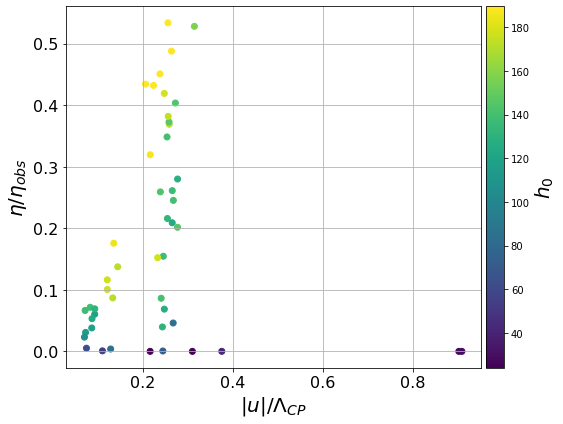

In [224]:
df=pd.read_csv("SCANS/BAU/sols_fullmodel_All.csv",index_col=[0])

plt.scatter(abs(df.u/df.Lam_CP),df.eta_BAU,c=df.h0)

plt.colorbar(orientation="vertical",pad=0.01).set_label( label="$h_0$", size=label_size, weight='bold')
#plt.axhline(y=d_eEDM_bound,linestyle="--",c="k")
#plt.xscale("log")
plt.grid(True)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.xlabel("$|u|/\\Lambda_{CP}$",size=label_size)
plt.ylabel("$\\eta/\\eta_{obs}$",size=label_size)
#plt.figtext(.47, .41, "ACME", fontsize=15)
#plt.xlim(0.1,.9)
plt.tight_layout()
#plt.savefig('SCANS/BAU_plots/EDM_plot.pdf', dpi=300)
plt.show()

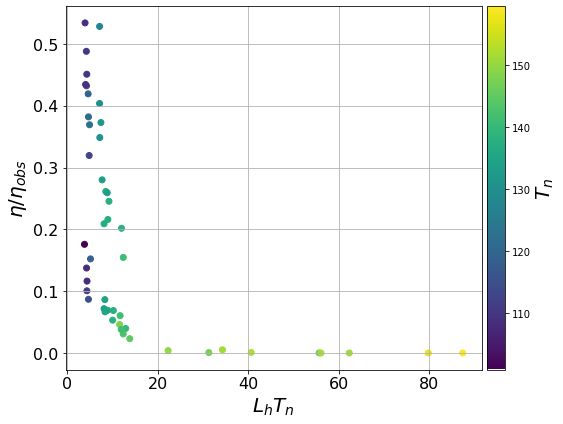

In [208]:
df=pd.read_csv("SCANS/BAU/sols_fullmodel_All.csv",index_col=[0])

plt.scatter(df.Lh*df.Tnuc_0,df.eta_BAU,c=df.Tnuc_0)

plt.colorbar(orientation="vertical",pad=0.01).set_label( label="$T_{n}$", size=label_size, weight='bold')
#plt.axhline(y=d_eEDM_bound,linestyle="--",c="k")
#plt.xscale("log")
plt.grid(True)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.xlabel("$L_h T_n$",size=label_size)
plt.ylabel("$\\eta/\\eta_{obs}$",size=label_size)
#plt.figtext(.47, .41, "ACME", fontsize=15)
#plt.xlim(0.1,.9)
plt.tight_layout()
#plt.savefig('SCANS/BAU_plots/EDM_plot.pdf', dpi=300)
plt.show()

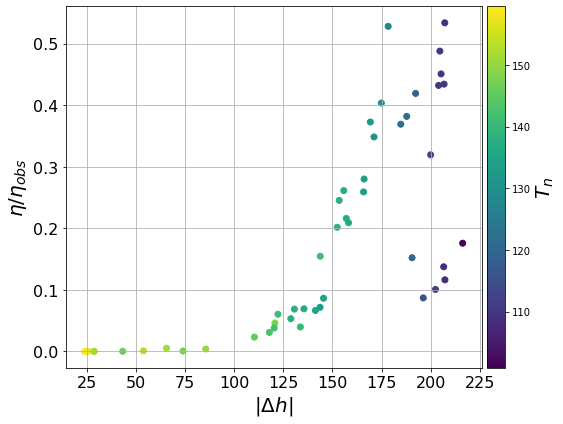

In [202]:
df=pd.read_csv("SCANS/BAU/sols_fullmodel_All.csv",index_col=[0])

plt.scatter(abs(df.h_low_0-df.h_high_0),df.eta_BAU,c=df.Tnuc_0)

plt.colorbar(orientation="vertical",pad=0.01).set_label( label="$T_{n}$", size=label_size, weight='bold')
#plt.axhline(y=d_eEDM_bound,linestyle="--",c="k")
#plt.yscale("log")
plt.grid(True)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.xlabel("$|\\Delta h|$",size=label_size)
plt.ylabel("$\\eta/\\eta_{obs}$",size=label_size)
#plt.figtext(.47, .41, "ACME", fontsize=15)
#plt.xlim(0.1,.9)
plt.tight_layout()
#plt.savefig('SCANS/BAU_plots/EDM_plot.pdf', dpi=300)
plt.show()

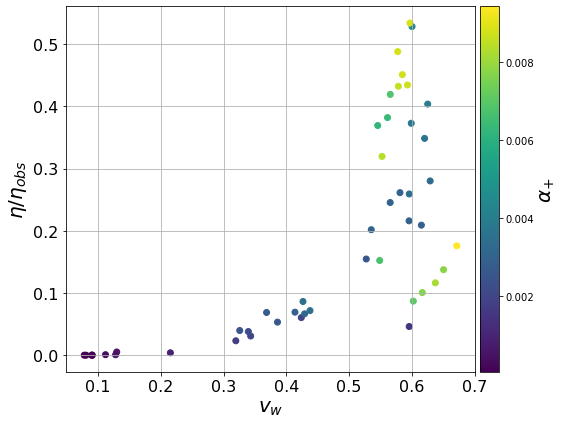

In [196]:
df=pd.read_csv("SCANS/BAU/sols_fullmodel_All.csv",index_col=[0])

plt.scatter(df.vw,df.eta_BAU,c=df.alpha_p)
plt.colorbar(orientation="vertical",pad=0.01).set_label( label="$\\alpha_{+}$", size=label_size, weight='bold')
#plt.axhline(y=d_eEDM_bound,linestyle="--",c="k")
#plt.yscale("log")
plt.grid(True)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.xlabel("$v_w$",size=label_size)
plt.ylabel("$\\eta/\\eta_{obs}$",size=label_size)
#plt.figtext(.47, .41, "ACME", fontsize=15)
#plt.xlim(0.1,.9)
plt.tight_layout()
#plt.savefig('SCANS/BAU_plots/EDM_plot.pdf', dpi=300)
plt.show()

In [6]:
df=pd.read_csv("SCANS/top_yukawa_rescaled_All.csv",index_col=[0]).sort_values("alpha_max",ascending=False)


modi=np.random.randint(0,len(df))
m=model1(ms = df.iloc[modi].ms, theta =df.iloc[modi].theta, muhs = df.iloc[modi].muhs,
         u = df.iloc[modi].u, mu3 =df.iloc[modi].mu3,Lam=df.iloc[modi].Lam_CP)

# np.random.seed()
# while True:
#     ms_val=np.random.uniform(1,1000)
#     theta_val=np.random.uniform(-.1,.1)
#     Lam_val=np.random.uniform(200,1000)
#     u_val=np.random.uniform(-Lam_val,Lam_val)
#     mu3_val=np.random.uniform(-1000,1000)
#     muhs_val=np.random.uniform(-1000,1000)
#     m=model1(ms = ms_val, theta =theta_val, muhs = muhs_val,
#              u = u_val, mu3 =mu3_val,Lam=Lam_val)
#     edm_Bool=d_eEDM([m.theta,m.ms,m.Lam])<d_eEDM_bound
#     thbool=m.theory_consistent()
#     EWSBbool=m.isEWSB()
#     EWSB_new=EWSBbool[0]==True  or (sum(EWSBbool[1]**2)**.5>Mplanck)
#     if edm_Bool==True and thbool==True and EWSB_new:
#         break
        
    
edm_Bool=d_eEDM([m.theta,m.ms,m.Lam])<d_eEDM_bound
thbool=m.theory_consistent()
EWSBbool=m.isEWSB()
m.print_couplings()
Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + m.yt**2/4 + m.lammix/24
Pis=m.lammix/6 + m.lams/4
lamh_tilde=m.lamh - m.lammix**2/4/m.lams
dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,"yt":m.yt,
      "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
      "muh2":m.muh2,"mus2":m.mus2,
      "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde,"Lam_CP":m.Lam}
dict_out.update({ "th_bool":thbool,"isEWSB": EWSBbool,"edm_Bool":edm_Bool})

try:
    alltrans=m.findAllTransitions()
    index=0
    count_trans=0
    alpha_list=[]
    dT_list=[]
    trans_types=[]
    for elem in alltrans:
        if elem["trantype"]==1:
            count_trans+=1
            phi_stable=elem["low_vev"]
            phi_meta=elem["high_vev"]
            SymNR=np.sum(m.findMinimum([0,0],1000)**2)**0.5>10
            dh,ds=abs(phi_meta-phi_stable)
            trans_types.append(trans_class(SymNR))
            Tnuc=elem["Tnuc"]
            Tc=elem["crit_trans"]["Tcrit"]
            dT=abs(m.phases[elem["high_phase"]].T[0]-m.phases[elem["low_phase"]].T[-1])
            dT_list.append(dT)
            Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
            alpha=alpha_GW(Tnuc,Delta_rho)
            alpha_list.append(alpha)
            Delta_pressure=m.Vtot(phi_meta,Tnuc) -m.Vtot(phi_stable,Tnuc)
            vwformula=(Delta_pressure/Delta_rho)**0.5
            xi_Jouguet=((alpha*(2+3*alpha))**0.5+1)/(3**0.5*(1+alpha))
            v_calculable=vwformula<xi_Jouguet
            dict_out.update({ "h_low_"+str(index):phi_stable[0],"s_low_"+str(index):phi_stable[1],
                             "h_high_"+str(index):phi_meta[0],"s_high_"+str(index):phi_meta[1],
                             "Tnuc_"+str(index):Tnuc,"dT_"+str(index):dT,"alpha_"+str(index):alpha,
                             "vwf_"+str(index):vwformula,"xi_J_"+str(index):xi_Jouguet,
                             "v_calculable_"+str(index):vwformula<xi_Jouguet})
            index+=1
    relevant_index=alpha_list.index(max(alpha_list))
    dict_out.update({"num_FOPT":count_trans,"alpha_max":max(alpha_list),
                     "dT_max":dT_list[relevant_index],
                     "tran_type":trans_types[relevant_index]})

except:
    print("error ocurred")

0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:260: RuntimeWarning: overflow encountered in multiply
  - 1.5)  + 2*n*m2*Mphys, axis=-1)


0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:259: RuntimeWarning: overflow encountered in multiply
  y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/Mphys) + 1e-100)


0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
0.0072992700729927005
Tracing phase starting at x = [ 246.20001791 -626.1611521 ] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
....................................................................................................................................................................................
Tracing phase starting at x = [ 7.38480122e-04 -6.25803191e+02] ; t = 161.05144892767433
Tracing minimum down
traceMinimum t0 = 161.051
...............................................
Tracing minimum up
traceMinimum t0 = 161.051
....................................................................................
error ocurred


In [7]:
dict_out

{'ms': 967.1196793187673,
 'theta': -0.0027395977721669518,
 'u': -626.1611519159508,
 'muhs': 392.71595150242774,
 'mu3': -763.617134655733,
 'yt': 0.7701557882172685,
 'lamh': 0.12913103373130916,
 'lams': 1.7782859759453933,
 'lammix': 0.6108368643485027,
 'muh2': -118328.48391944864,
 'mus2': 218583.72282150976,
 'Pih': 0.3228035193233929,
 'Pis': 0.5463776380444321,
 'lamh_tilde': 0.07667579313808176,
 'Lam_CP': 756.0354732720604,
 'th_bool': True,
 'isEWSB': (False, array([-1.89337049e+40, -1.62074858e+39])),
 'edm_Bool': True}

In [9]:
alltrans

[{'Tnuc': 160.06988988492384,
  'low_vev': array([ 1.99933092e-02, -6.25804522e+02]),
  'high_vev': array([ 1.99933092e-02, -6.25804522e+02]),
  'low_phase': 0,
  'high_phase': 1,
  'action': 0.0,
  'instanton': None,
  'trantype': 2,
  'crit_trans': {'Tcrit': 160.06988988492384,
   'low_vev': array([ 1.99933092e-02, -6.25804522e+02]),
   'high_vev': array([ 1.99933092e-02, -6.25804522e+02]),
   'low_phase': 0,
   'high_phase': 1,
   'action': 0.0,
   'instanton': None,
   'trantype': 2,
   'Delta_rho': 0.0},
  'Delta_rho': 0.0,
  'Delta_p': 0.0}]

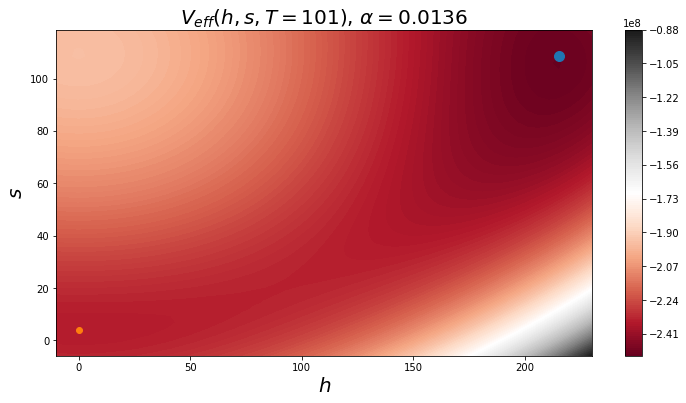

In [10]:
clevs=50
myN = 170
index_trans=0
Temp=df.iloc[modi]["Tnuc_"+str(index_trans)]

X_1=[df.iloc[modi]["h_low_"+str(index_trans)],df.iloc[modi]["s_low_"+str(index_trans)]]
X_2=[df.iloc[modi]["h_high_"+str(index_trans)],df.iloc[modi]["s_high_"+str(index_trans)]]

smax=max(df.iloc[modi]["s_high_"+str(index_trans)],df.iloc[modi]["s_low_"+str(index_trans)])
smin=min(df.iloc[modi]["s_high_"+str(index_trans)],df.iloc[modi]["s_low_"+str(index_trans)])
hmax=max(df.iloc[modi]["h_high_"+str(index_trans)],df.iloc[modi]["h_low_"+str(index_trans)])
hmin=min(df.iloc[modi]["h_high_"+str(index_trans)],df.iloc[modi]["h_low_"+str(index_trans)])
box=(hmin-10,hmax+15,smin-10,smax+10)

xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + "), "+"$\\alpha=$"+str(np.round(df.iloc[modi]["alpha_"+str(index_trans)],4)),size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
fig.colorbar(cf1, ax=ax1)
ax1.scatter(X_1[0],X_1[1],s=100)
ax1.scatter(X_2[0],X_2[1])
plt.show()

In [11]:
some_bubble=bubble(m)
some_bubble.test_analytic_formula()
some_bubble.potential_barrier()
some_bubble.initial_guess()



 (dV/alpha rho_r)^0.5 = 0.5887239159099107
xi_Jouguet= 0.6643182251177627
 Lh*Tnuc= 4.597544043532315
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5887239159099107, 'Lh': 0.04542832439476506, 'dh': 0, 'h0': 214.39208104352093, 'Ls': 0.04542832439476506, 'ds': 0, 'shigh': 4.112509762993535, 'slow': 106.11516561502027}


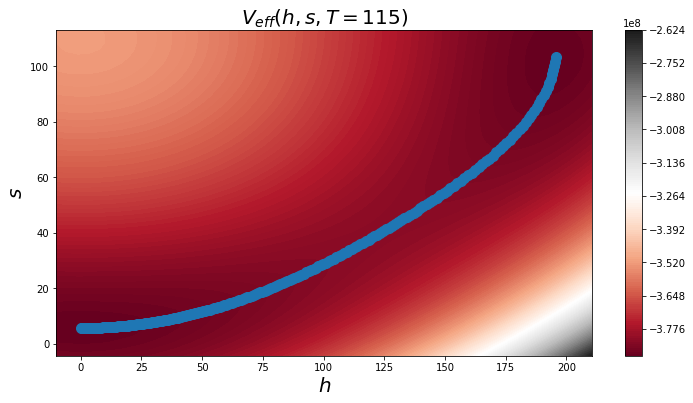

In [12]:
some_bubble.print_barrier1()


In [11]:
LT_max=some_bubble.LT*2
LT_min=some_bubble.LT*.5
if LT_min<1:
    LT_min=1
vmin=some_bubble.vformula*(1-.15)
vmax=some_bubble.xi_Jouguet
LT_max,LT_min,vmin,vmax

(10.27031687024212, 2.56757921756053, 0.46547593504500984, 0.653710177711545)

In [12]:
%%time
#some_bubble=bubble(m)
#some_bubble.test_analytic_formula()
#some_bubble.potential_barrier()
#some_bubble.initial_guess()

LT_max=some_bubble.LT*2
LT_min=some_bubble.LT*.5
if LT_min<1:
    LT_min=1
vmin=some_bubble.vformula*(1-.15)
vmax=some_bubble.xi_Jouguet
some_bubble.grid_scan((vmin,vmax,6),(LT_min/some_bubble.T,LT_max/some_bubble.T,6))

#LT_max=15
#LT_min=5
#vmin=0.3
#vmax=0.58
#some_bubble.grid_scan((vmin,vmax,6),(LT_min/some_bubble.T,LT_max/some_bubble.T,6))



This is a Deflagration  
................
Finding alpha+ 
...........


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:195: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


........
 Finding velocity and temperature in front of the wall:
v_+=0.437903,   T_+=108.493057
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}
This is a Jouguet detonation
Finding alpha+ 
...........


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:255: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:255: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


alpha+ = 0.006146
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.509910, T+=120.942009
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=191.149322, slow=105.555224, shigh=6.736764
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.653710177711545, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 191.14932221602515, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 6.736764076184086, 'slow': 105.55522447204234}

....
 Performing grid scan on a box=(0.46547593504500984, 0.653710177711545, 0.0240852722146655, 0.038536435543464795)
 ......

Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}

......
 Evaluating grid at point (v,L)=(0.46547593504

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:484: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in double_scalars
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/si

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.024,  ds=0.505
New guess is given by: 
 ...........
{'vw': 0.46547593504500984, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 207.4168205798932, 'Ls': 0.02408524833811301, 'ds': 0.5045114051295252, 'shigh': 5.105089343780058, 'slow': 109.46244584659058}
Solving Boltzmann transport equations for vw=0.43790310145147343, Lh=0.0240852722146655, T+=108.49305736595288
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-

Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=208.1914958440289.

guess dict has been updated   
......................
h0=208.191
New guess is given by: 
 ...........
{'vw': 0.46547593504500984, 'Lh': 0.0674387622010634, 'dh': 0, 'h0': 208.1914958440289, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.105089343780058, 'slow': 109.46244584659058}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.067,  ds=0.497
New guess is given by: 
 ...........
{'vw': 0.46547593504500984, 'Lh': 0.0674387622010634, 'dh': 0, 'h0': 208.1914958440

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:195: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


........
 Finding velocity and temperature in front of the wall:
v_+=0.466403,   T_+=109.329943
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=208.004276, slow=109.299363, shigh=5.203604
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.5031227835783169, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 208.00427622718036, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.203603650576458, 'slow': 109.29936318393854}
Solving Boltzmann transport equations for vw=0.46640327833018425, Lh=0.0240852722146655, T+=109.32994312444119
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations 

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:340: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=206.28892830661997.

guess dict has been updated   
......................
h0=206.289
New guess is given by: 
 ...........
{'vw': 0.5031227835783169, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 206.28892830661997, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.203603650576458, 'slow': 109.29936318393854}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.024,  ds=0.512
New guess is given by: 
 ...........
{'vw': 0.5031227835783169, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 206.28892830661997, 'Ls': 0.024085247996625946, 'ds': 0.5120713216483946, 'shigh': 5.203603650576458, 'slow': 109.29936318393854}
Solving Boltzmann transport equations for vw=0.46640327833018425, Lh=0.0240852722146655, T+=109.32994312444119
.......
Initializ

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=207.1181240256258.

guess dict has been updated   
......................
h0=207.118
New guess is given by: 
 ...........
{'vw': 0.5031227835783169, 'Lh': 0.0674387622010634, 'dh': 0, 'h0': 207.1181240256258, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.203603650576458, 'slow': 109.29936318393854}


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:484: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.067,  ds=0.504
New guess is given by: 
 ...........
{'vw': 0.5031227835783169, 'Lh': 0.0674387622010634, 'dh': 0, 'h0': 207.1181240256258, 'Ls': 0.06743873818926403, 'ds': 0.5038125330281157, 'shigh': 5.203603650576458, 'slow': 109.29936318393854}
Solving Boltzmann transport equations for vw=0.46640327833018425, Lh=0.0674387622010634, T+=109.32994312444119
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1

Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=204.36907408868143.

guess dict has been updated   
......................
h0=204.369
New guess is given by: 
 ...........
{'vw': 0.5407696321116239, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 204.36907408868143, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.3777199654042285, 'slow': 108.99521451427248}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.024,  ds=0.525
New guess is given by: 
 ...........
{'vw': 0.5407696321116239, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 204.369074088

init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=206.185642, slow=108.995215, shigh=5.377720
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.5407696321116239, 'Lh': 0.0674387622010634, 'dh': 0, 'h0': 206.1856416279532, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.3777199654042285, 'slow': 108.99521451427248}
Solving Boltzmann transport equations for vw=0.48871738097888606, Lh=0.0674387622010634, T+=110.77738205585378
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
.......

Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}

......
 Evaluating grid at point (v,L)=(0.578416480644931,0.0240852722146655)
 ......

This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.007961
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.500083, T+=113.366726
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=202.755826, slow=108.368527, shigh=5.700982
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.578416480644931, 'Lh': 0.0240852722146655, 'dh': 0, 'h0': 202.7558255831304, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.700981601915583, 'slow': 108.

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}

......
 Evaluating grid at point (v,L)=(0.578416480644931,0.0674387622010634)
 ......

This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.007961
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.500083, T+=113.366726
init_h0_s0 WAS SUCCESSFUL 
 UPDATING S

update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.096,  ds=1.000
New guess is given by: 
 ...........
{'vw': 0.578416480644931, 'Lh': 0.096341088858662, 'dh': 0, 'h0': 201.90837788661088, 'Ls': 0.09634104109016636, 'ds': 0.9999999999999989, 'shigh': 5.700981601915583, 'slow': 108.36852707983533}
Solving Boltzmann transport equations for vw=0.5000829536864073, Lh=0.096341088858662, T+=113.36672591161742
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} h

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=196.44645809248155.

guess dict has been updated   
......................
h0=196.446
New guess is given by: 
 ...........
{'vw': 0.616063329178238, 'Lh': 0.0529875988722641, 'dh': 0, 'h0': 196.44645809248155, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 6.167889384635783, 'slow': 107.2856201657242}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0

...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
update_h0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Modified Higgs amplitude profile h0=196.76356866427548.

guess dict has been updated   
......................
h0=196.764
New guess is given by: 
 ...........
{'vw': 0.616063329178238, 'Lh': 0.096341088858662, 'dh': 0, 'h0': 196.76356866427548, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 6.167889384635783, 'slow': 107.2856201657242}
update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.

init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=191.149322, slow=105.555224, shigh=6.736764
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.653710177711545, 'Lh': 0.0529875988722641, 'dh': 0, 'h0': 191.14932221602515, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 6.736764076184086, 'slow': 105.55522447204234}
Solving Boltzmann transport equations for vw=0.5099099642294682, Lh=0.0529875988722641, T+=120.94200911260103
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
.........

Interpolation finished succesfully 
..............
Solving transport equations for fluid perturbations 
.......
Solving transport equations for background perturbations 
.......
Solution is complete and added to All_Solutions.  
..............
Interpolating function for D_v^{0,-1} has been added.
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}

......
 Evaluating grid at point (v,L)=(0.653710177711545,0.096341088858662)
 ......

This is a Jouguet detonation
Finding alpha+ 
...........
alpha+ = 0.006146
integrating the deflagration component 
........
 Finding velocity and temperature in front of the wall:
 v+=0.509910, T+=120.942009
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=191.149322, slow=105.555224, shigh=6.736764
guess di

[array([[0.46547594, 0.50312278, 0.54076963, 0.57841648, 0.61606333,
         0.65371018],
        [0.46547594, 0.50312278, 0.54076963, 0.57841648, 0.61606333,
         0.65371018],
        [0.46547594, 0.50312278, 0.54076963, 0.57841648, 0.61606333,
         0.65371018],
        [0.46547594, 0.50312278, 0.54076963, 0.57841648, 0.61606333,
         0.65371018],
        [0.46547594, 0.50312278, 0.54076963, 0.57841648, 0.61606333,
         0.65371018],
        [0.46547594, 0.50312278, 0.54076963, 0.57841648, 0.61606333,
         0.65371018]]),
 array([[0.02408527, 0.02408527, 0.02408527, 0.02408527, 0.02408527,
         0.02408527],
        [0.03853644, 0.03853644, 0.03853644, 0.03853644, 0.03853644,
         0.03853644],
        [0.0529876 , 0.0529876 , 0.0529876 , 0.0529876 , 0.0529876 ,
         0.0529876 ],
        [0.06743876, 0.06743876, 0.06743876, 0.06743876, 0.06743876,
         0.06743876],
        [0.08188993, 0.08188993, 0.08188993, 0.08188993, 0.08188993,
         0.08188993

In [13]:
vel_converged=some_bubble.find_min_grid()

SOLUTION WAS FOUND WITH ROOT FINDER 
 ...................
 ....... 
 ........
The solution found is:
[vw,L] = [0.54968432 0.0850636 ]
Finding full guess dict solution
Initial v_w <= v_Jouguet 
The inital fitted guess is 

{'vw': 0.5476187471117763, 'Lh': 0.048170544429331, 'dh': 0, 'h0': 211.2524564747024, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 4.888354885212934, 'slow': 109.80034470660274}
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.492593,   T_+=111.265693
init_h0_s0 WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
Updated profile amplitues found 

h0=205.556617, slow=108.885666, shigh=5.437502
guess dict has been updated   
......................
New guess is given by: 
 ...........
{'vw': 0.5496843226987334, 'Lh': 0.08506360041548208, 'dh': 0, 'h0': 205.55661699322982, 'Ls': 0.048170544429331, 'ds': 0, 'shigh': 5.437502287053794, 'slow': 108.8856662394935}

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:484: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:525: RuntimeWarning: divide by zero encountered in double_scalars
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:485: RuntimeWarning: divide by zero encountered in double_scalars


update_Ls WAS SUCCESSFUL 
 UPDATING SCALAR SINGLET PARAMETERS 
......................
guess dict has been updated   
......................
Ls=0.085,  ds=0.519
New guess is given by: 
 ...........
{'vw': 0.5496843226987334, 'Lh': 0.08506360041548208, 'dh': 0, 'h0': 204.70813503721791, 'Ls': 0.08506357564700887, 'ds': 0.5191059060891569, 'shigh': 5.437502287053794, 'slow': 108.8856662394935}
Hydrodynamics taken into acount
This is a Deflagration  
................
Finding alpha+ 
...........
........
 Finding velocity and temperature in front of the wall:
v_+=0.492593,   T_+=111.265693
Solving Boltzmann transport equations for vw=0.49259286502805, Lh=0.08506360041548208, T+=111.26569291322703
.......
Initializing interpolation for damping term $A^{-1}\Gamma$
...........
...........
...........
...........
...........
...........
...........
Initializing interpolation for source term $A^{-1}S$
...........
Interpolation finished succesfully 
..............
Solving transport equations for 

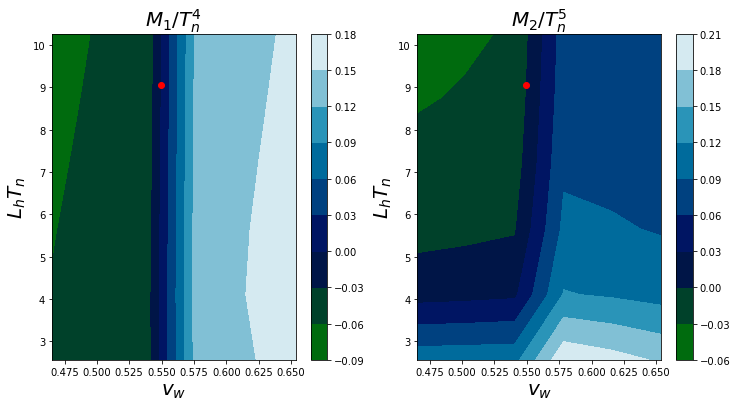

alpha =0.00857977176739681, alpha_N=0.01018196669466221


In [108]:
some_bubble.print_gridmap()

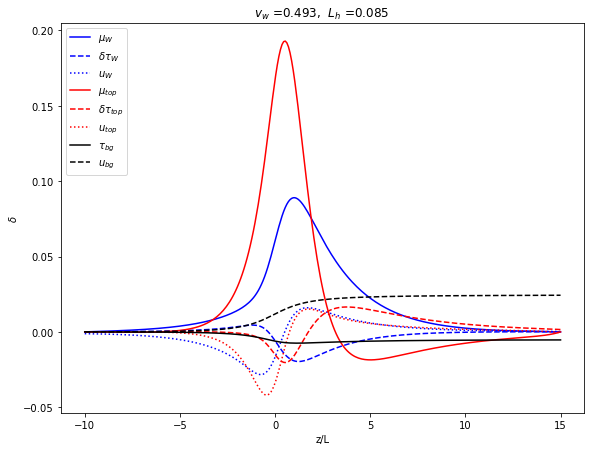

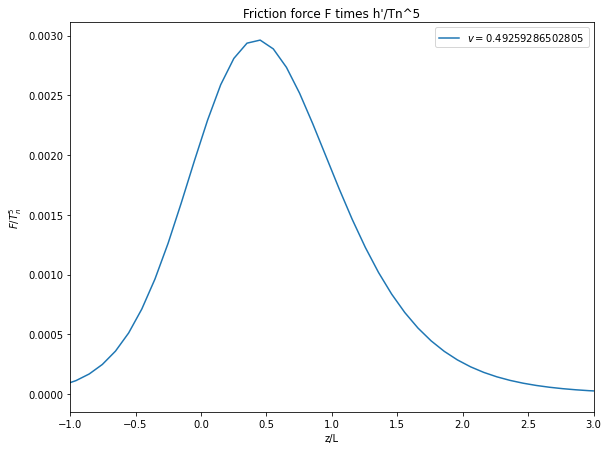

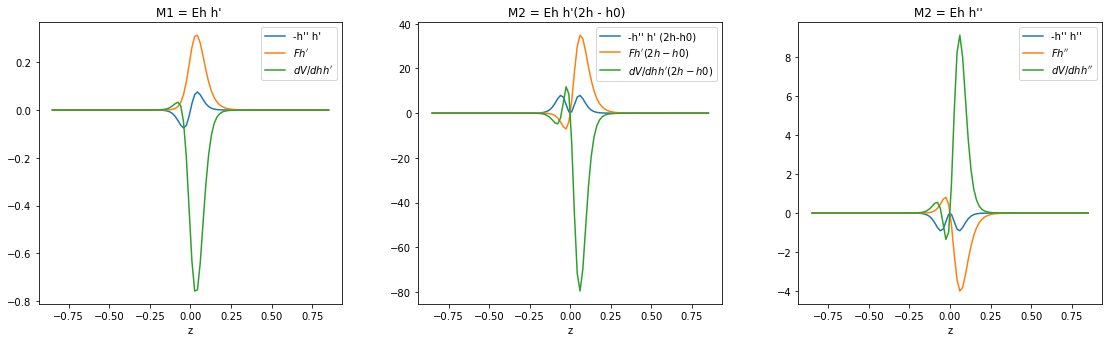

In [109]:
some_bubble.my_print()
some_bubble.print_friction()
some_bubble.print_contribs()


In [110]:
vel_converged

(True,
 {'vw': 0.5496843226987334,
  'Lh': 0.08506360041548208,
  'dh': 0,
  'h0': 204.70813503721791,
  'Ls': 0.08506357564700887,
  'ds': 0.5191059060891569,
  'shigh': 5.437502287053794,
  'slow': 108.8856662394935},
 0.0019357507937419025)